In [1]:
!pip install category_encoders

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelBinarizer
from category_encoders import TargetEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.compose import ColumnTransformer

from mpl_toolkits.mplot3d import Axes3D

# Modèles linéaires
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Modèles ensembliste
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

# Modèle de Support Vector
from sklearn.svm import SVR

# Modèle de régression KNN
from sklearn import neighbors
from sklearn.neighbors import KNeighborsRegressor

# Modèle dummy
from sklearn.dummy import DummyRegressor

# Métriques 
from sklearn.metrics import *


# Pipeline 
from sklearn.pipeline import make_pipeline, Pipeline

from timeit import default_timer as timer

import sys
import os
import warnings
warnings.filterwarnings("ignore")

%run my_function.ipynb

import warnings
warnings.filterwarnings('ignore')

In [3]:
path = 'C:/Users/Farid/Documents/OC/Cursus_Data_Scientist/Projet_4/data'

In [4]:
os.listdir(path)

['2016_Building_Energy_Benchmarking.csv', 'energy_cleaned.csv']

In [5]:
energy_benchmarking = pd.read_csv(path + '/energy_cleaned.csv')
energy_benchmarking_ml = energy_benchmarking.copy()

In [6]:
energy_benchmarking_ml.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  ZipCode  \
0              1      2016  NonResidential               Hotel  98101.0   
1              2      2016  NonResidential               Hotel  98101.0   
2              3      2016  NonResidential               Hotel  98101.0   
3              5      2016  NonResidential               Hotel  98101.0   
4              8      2016  NonResidential               Hotel  98121.0   

  TaxParcelIdentificationNumber  CouncilDistrictCode Neighborhood  \
0                    0659000030                    7     DOWNTOWN   
1                    0659000220                    7     DOWNTOWN   
2                    0659000475                    7     DOWNTOWN   
3                    0659000640                    7     DOWNTOWN   
4                    0659000970                    7     DOWNTOWN   

   NumberofBuildings  NumberofFloors  ...  Electricity(kBtu) NaturalGas(kBtu)  \
0                1.0              12  ...          3946027.0        1276453.0   
1                1.0              11  ...          3242851.0        5145082.0   
2                1.0              41  ...         49526664.0        1493800.0   
3                1.0              10  ...          2768924.0        1811213.0   
4                1.0              18  ...          5368607.0        8803998.0   

  ComplianceStatus  TotalGHGEmissions  GHGEmissionsIntensity  Ancienneté  \
0        Compliant             249.98                   2.83          89   
1        Compliant             295.86                   2.86          20   
2        Compliant            2089.28                   2.19          47   
3        Compliant             286.43                   4.67          90   
4        Compliant             505.01                   2.88          36   

   BuildingAreaPercentage  ParkingAreaPercentage  AverageGFAperBuilding  \
0                 1.00000                0.00000                88434.0   
1                 0.85455                0.14545               103566.0   
2                 0.79425                0.20575               956110.0   
3                 1.00000                0.00000                61320.0   
4                 0.64688                0.35312               175580.0   

   AverageGFAperFloor  
0             7369.50  
1             9415.09  
2            23319.76  
3             6132.00  
4             9754.44  

[5 rows x 29 columns]

In [7]:
energy_benchmarking_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1618 entries, 0 to 1617
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1618 non-null   int64  
 1   DataYear                       1618 non-null   int64  
 2   BuildingType                   1618 non-null   object 
 3   PrimaryPropertyType            1618 non-null   object 
 4   ZipCode                        1602 non-null   float64
 5   TaxParcelIdentificationNumber  1618 non-null   object 
 6   CouncilDistrictCode            1618 non-null   int64  
 7   Neighborhood                   1618 non-null   object 
 8   NumberofBuildings              1618 non-null   float64
 9   NumberofFloors                 1618 non-null   int64  
 10  PropertyGFATotal               1618 non-null   int64  
 11  ListOfAllPropertyUseTypes      1618 non-null   object 
 12  LargestPropertyUseType         1618 non-null   o

# Fonction 

In [8]:
# fonction titre 
def print_titre(titre):
    longueur_ligne = len(titre) + 10
    ligne = "-" * longueur_ligne

    print(ligne)
    print(f"| {titre} |")
    print(ligne)
    return

In [9]:
def select_features_and_targets(df, col):
    selected_columns = numeric_features + categorical_features + [col]
    df_selected = df[selected_columns]

    return df_selected

In [10]:
def train_model(pipeline, grid, X_train, y_train):
    cv_model = GridSearchCV(pipeline, grid, cv=5, n_jobs=-1, return_train_score=True, verbose=2)
    cv_model.fit(X_train, y_train)
    
    return cv_model

In [11]:
def display_evaluate_model(cv_model, X_test, y_test, model_name, config_name, df_cv_results):
    """
    Affiche et évalue les résultats d'un modèle avec une configuration spécifique.

    Parameters:
    - cv_model: Modèle après la recherche sur grille (GridSearchCV).
    - X_test (DataFrame): Features de test.
    - y_test (Series): Labels de test.
    - model_name (str): Nom du modèle.
    - config_name (str): Nom de la configuration.
    - df_cv_results (DataFrame): Résultats de la recherche sur grille.

    Returns:
    - dict: Informations sur les résultats du modèle.
    """
    # Info sur les résultats du modèle
    result_info = {
        "model_name": model_name,
        "config_name": config_name,
        "Test score": cv_model.best_score_,
        "Test_score_best_estimator": cv_model.best_estimator_.score(X_test, y_test),
        "Params": cv_model.best_params_,
        "df_cv_results": df_cv_results
    }
    
    print_titre(f"Meilleur Model - {model_name}")
    print(f'{model_name} - {config_name}:\n Test score: {cv_model.best_score_}\n Params: {cv_model.best_params_}\n')
    
    print_titre("Details Models")
    print(df_cv_results)
    
    # Courbe d'apprentissage
    print_titre("Courbe d'apprentissage")
    plt.figure(figsize=(4, 3))
    N, train_score, val_score = learning_curve(cv_model.best_estimator_, X_train, y_train, train_sizes=np.linspace(0.2, 1.0, 5), cv=5)
    plt.plot(N, train_score.mean(axis=1), label='Entraînement')
    plt.plot(N, val_score.mean(axis=1), label='Validation')
    plt.xlabel('Taille de l\'ensemble d\'entraînement')
    plt.ylabel('Score moyen')
    plt.legend()
    plt.show()

    # Scores Moyens d'Entraînement et de Validation
    print_titre("Scores Moyens d'Entraînement et de Validation")
    plt.figure(figsize=(4, 3))
    plt.plot(cv_model.cv_results_["mean_train_score"], label='Entraînement')
    plt.plot(cv_model.cv_results_["mean_test_score"], label='Validation')
    plt.xlabel('Nombre d\'itérations')
    plt.ylabel('Score (R^2)')
    plt.show()

    return result_info

In [12]:
def run_models_with_preprocessors(models, preprocessor_configs, grid_configs, X_train, y_train, X_test, y_test, numeric_features, categorical_features):
    """
    Entraîne plusieurs modèles avec différentes configurations de prétraitement et affiche les résultats.

    Parameters:
    - models (dict): Dictionnaire de modèles à entraîner.
    - preprocessor_configs (list): Liste de tuples contenant le nom de la configuration, le préprocesseur numérique et le préprocesseur catégorique.
    - grid_configs (dict): Dictionnaire contenant les grilles de recherche spécifiques à chaque modèle.
    - X_train (DataFrame): Features d'entraînement.
    - y_train (Series): Labels d'entraînement.
    - X_test (DataFrame): Features de test.
    - y_test (Series): Labels de test.
    - numeric_features (list): Liste des colonnes numériques.
    - categorical_features (list): Liste des colonnes catégoriques.

    Returns:
    - dict: Résultats de l'évaluation pour chaque modèle et configuration.
    """
    results = {}

    for model_name, model in models.items():
        for config_name, num_preprocessor, cat_preprocessor in preprocessor_configs:
            # Création du préprocesseur
            preprocessor = ColumnTransformer(
                transformers=[
                    ("num", num_preprocessor, numeric_features),
                    ("cat", cat_preprocessor, categorical_features),
                ]
            )

            # Création de la pipeline
            pipeline = Pipeline(
                steps=[("preprocessor", preprocessor), ("regressor", model)]
            )

            # Création de la grille de recherche spécifique au modèle
            grid = grid_configs.get(model_name, {})  # Utiliser une grille vide si le modèle n'est pas trouvé dans grid_configs

            # Entraînement du modèle
            cv_model = train_model(pipeline, grid, X_train, y_train)

            # Affichage des résultats
            df_cv_results = pd.DataFrame(cv_model.cv_results_).sort_values(by="rank_test_score", ascending=True)[['params', "mean_train_score", "mean_test_score"]]
            result_info = display_evaluate_model(cv_model, X_test, y_test, model_name, config_name, df_cv_results)
            results[f"{model_name} - {config_name}"] = result_info

    return results

# Analyse Comparative des Modèles Utilisés

In [13]:
energy_benchmarking_ml.columns

Index(['OSEBuildingID', 'DataYear', 'BuildingType', 'PrimaryPropertyType',
       'ZipCode', 'TaxParcelIdentificationNumber', 'CouncilDistrictCode',
       'Neighborhood', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFATotal', 'ListOfAllPropertyUseTypes',
       'LargestPropertyUseType', 'ENERGYSTARScore', 'SiteEUIWN(kBtu/sf)',
       'SourceEUIWN(kBtu/sf)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'ComplianceStatus', 'TotalGHGEmissions', 'GHGEmissionsIntensity',
       'Ancienneté', 'BuildingAreaPercentage', 'ParkingAreaPercentage',
       'AverageGFAperBuilding', 'AverageGFAperFloor'],
      dtype='object')

In [14]:
numeric_features = ['Ancienneté', 'BuildingAreaPercentage', 'ParkingAreaPercentage',
                     'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'ENERGYSTARScore']

categorical_features = ['Neighborhood', 'PrimaryPropertyType', 'BuildingType', 'LargestPropertyUseType']

In [15]:
energy_benchmarking_ml = energy_benchmarking_ml[numeric_features + categorical_features + ['TotalGHGEmissions']]

In [16]:
energy_benchmarking_ml.columns

Index(['Ancienneté', 'BuildingAreaPercentage', 'ParkingAreaPercentage',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'ENERGYSTARScore', 'Neighborhood', 'PrimaryPropertyType',
       'BuildingType', 'LargestPropertyUseType', 'TotalGHGEmissions'],
      dtype='object')

In [17]:
# Diviser les données
X = energy_benchmarking_ml.dropna().drop(columns=['TotalGHGEmissions'])
y = energy_benchmarking_ml.dropna()['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1073 entries, 0 to 1613
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Ancienneté              1073 non-null   int64  
 1   BuildingAreaPercentage  1073 non-null   float64
 2   ParkingAreaPercentage   1073 non-null   float64
 3   NumberofBuildings       1073 non-null   float64
 4   NumberofFloors          1073 non-null   int64  
 5   PropertyGFATotal        1073 non-null   int64  
 6   ENERGYSTARScore         1073 non-null   float64
 7   Neighborhood            1073 non-null   object 
 8   PrimaryPropertyType     1073 non-null   object 
 9   BuildingType            1073 non-null   object 
 10  LargestPropertyUseType  1073 non-null   object 
dtypes: float64(4), int64(3), object(4)
memory usage: 100.6+ KB


In [19]:
y.info()

<class 'pandas.core.series.Series'>
Int64Index: 1073 entries, 0 to 1613
Series name: TotalGHGEmissions
Non-Null Count  Dtype  
--------------  -----  
1073 non-null   float64
dtypes: float64(1)
memory usage: 16.8 KB


In [20]:
# Liste des modèles à tester
models = {
    "KNN": KNeighborsRegressor(),
    "ElasticNet": ElasticNet(),
    "GradientBoosting": GradientBoostingRegressor(),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor()
}

# Grilles de recherche pour chaque modèle
grid_configs = {
    "KNN": {"regressor__n_neighbors": range(2, 15)},
    "ElasticNet": {"regressor__alpha": np.logspace(0.00001, 10, 30), "regressor__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]},
    "GradientBoosting": {"regressor__n_estimators": np.linspace(10, 400, 30, dtype=int), "regressor__learning_rate": [1, 0.5, 0.25, 0.1, 0.05, 0.01]},
    "SVR": {"regressor__C": np.logspace(-2, 3, 6)},
    "RandomForest": {"regressor__n_estimators": np.linspace(10, 200, 20,dtype=int), "regressor__min_samples_leaf": [1, 4]}
}

# Liste des préprocesseurs pour tester différentes combinaisons
preprocessor_configs = [
    ("RobustScaler + OneHotEncoder", RobustScaler(), OneHotEncoder(handle_unknown='ignore')),
    ("StandardScaler + OneHotEncoder", StandardScaler(), OneHotEncoder(handle_unknown='ignore')),
    ("MinMaxScaler + OneHotEncoder", MinMaxScaler(), OneHotEncoder(handle_unknown='ignore')),
    ("PolynomialFeatures + OneHotEncoder", PolynomialFeatures(), OneHotEncoder(handle_unknown='ignore')),
    ("RobustScaler + TargetEncoder", RobustScaler(), TargetEncoder(cols=categorical_features)),
    ("StandardScaler + TargetEncoder", StandardScaler(), TargetEncoder(cols=categorical_features)),
    ("MinMaxScaler + TargetEncoder", MinMaxScaler(), TargetEncoder(cols=categorical_features)),
    ("PolynomialFeatures + TargetEncoder", PolynomialFeatures(), TargetEncoder(cols=categorical_features)),
]

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - RobustScaler + OneHotEncoder:
 Test score: 0.42680227348352046
 Params: {'regressor__n_neighbors': 6}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
4    {'regressor__n_neighbors': 6}          0.404359         0.426802
5    {'regressor__n_neighbors': 7}          0.389314         0.416311
3    {'regressor__n_neighbors': 5}          0.451170         0.353754
7    {'regressor__n_neighbors': 9}          0.345290         0.296450
6    {'regressor__n_neighbors': 8}          0.368066         0.278464
1    {'regressor__n_neighbors': 3}          0.629304         0.274874
12  {'regressor__n_neighbors': 14}          0.280508         0.269210
0    {'regressor__n_neighbors': 2}          0.788922         0.262215
2    {'regressor__n_neighbors': 4}          

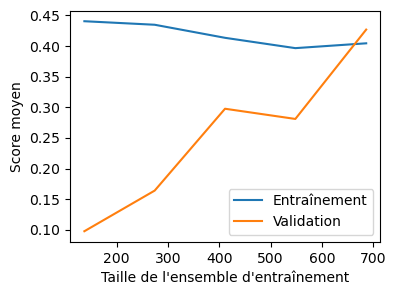

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


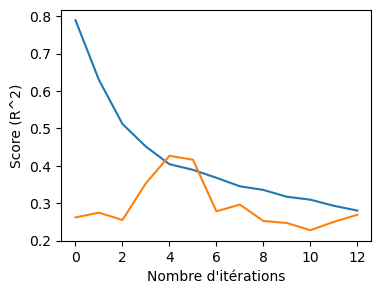

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - StandardScaler + OneHotEncoder:
 Test score: 0.25376280491900505
 Params: {'regressor__n_neighbors': 12}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
10  {'regressor__n_neighbors': 12}          0.258887         0.253763
11  {'regressor__n_neighbors': 13}          0.255314         0.251770
12  {'regressor__n_neighbors': 14}          0.249978         0.249720
9   {'regressor__n_neighbors': 11}          0.272976         0.197570
8   {'regressor__n_neighbors': 10}          0.281500         0.188447
7    {'regressor__n_neighbors': 9}          0.300773         0.164913
6    {'regressor__n_neighbors': 8}          0.316951         0.140381
5    {'regressor__n_neighbors': 7}          0.339765         0.139729
4    {'regressor__n_neighbors': 6}       

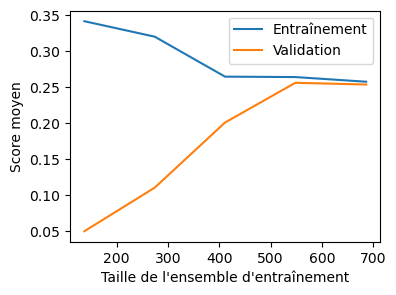

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


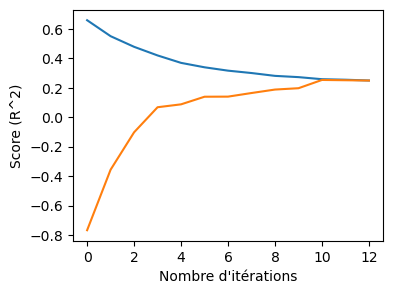

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - MinMaxScaler + OneHotEncoder:
 Test score: 0.3001233433469584
 Params: {'regressor__n_neighbors': 4}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
2    {'regressor__n_neighbors': 4}          0.487026         0.300123
1    {'regressor__n_neighbors': 3}          0.578980         0.295760
0    {'regressor__n_neighbors': 2}          0.731230         0.295650
3    {'regressor__n_neighbors': 5}          0.431338         0.266124
5    {'regressor__n_neighbors': 7}          0.362293         0.259677
4    {'regressor__n_neighbors': 6}          0.394663         0.254243
6    {'regressor__n_neighbors': 8}          0.332781         0.237162
7    {'regressor__n_neighbors': 9}          0.305806         0.231822
9   {'regressor__n_neighbors': 11}          0

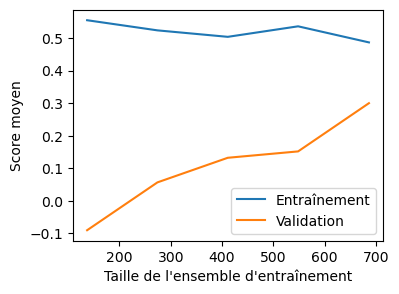

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


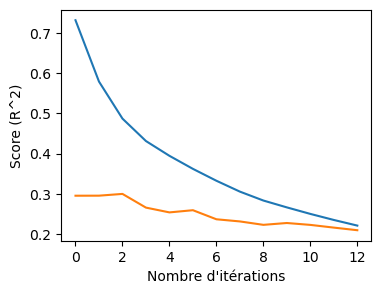

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - PolynomialFeatures + OneHotEncoder:
 Test score: -0.07871494324857456
 Params: {'regressor__n_neighbors': 14}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
12  {'regressor__n_neighbors': 14}          0.171865        -0.078715
10  {'regressor__n_neighbors': 12}          0.180403        -0.099375
11  {'regressor__n_neighbors': 13}          0.168768        -0.118991
9   {'regressor__n_neighbors': 11}          0.182509        -0.168000
8   {'regressor__n_neighbors': 10}          0.186164        -0.218768
6    {'regressor__n_neighbors': 8}          0.194876        -0.359221
7    {'regressor__n_neighbors': 9}          0.171937        -0.374190
5    {'regressor__n_neighbors': 7}          0.209694        -0.507805
2    {'regressor__n_neighbors': 4}  

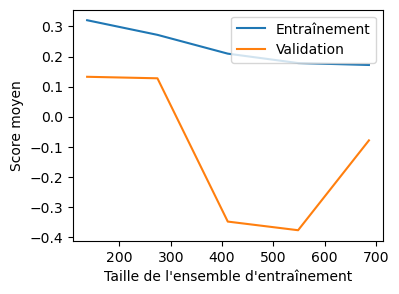

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


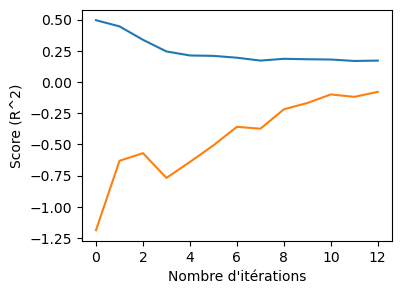

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - RobustScaler + TargetEncoder:
 Test score: 0.2827424636630257
 Params: {'regressor__n_neighbors': 2}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
0    {'regressor__n_neighbors': 2}          0.794541         0.282742
10  {'regressor__n_neighbors': 12}          0.271349         0.207767
11  {'regressor__n_neighbors': 13}          0.258321         0.207375
9   {'regressor__n_neighbors': 11}          0.285187         0.205869
8   {'regressor__n_neighbors': 10}          0.301627         0.203495
12  {'regressor__n_neighbors': 14}          0.247801         0.202284
7    {'regressor__n_neighbors': 9}          0.315932         0.188448
6    {'regressor__n_neighbors': 8}          0.332458         0.164698
5    {'regressor__n_neighbors': 7}          0

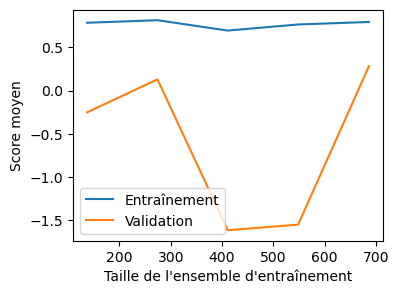

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


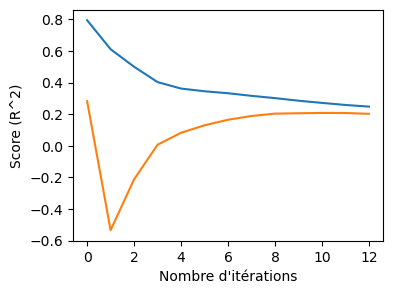

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - StandardScaler + TargetEncoder:
 Test score: 0.3519097216165106
 Params: {'regressor__n_neighbors': 2}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
0    {'regressor__n_neighbors': 2}          0.797644         0.351910
9   {'regressor__n_neighbors': 11}          0.277282         0.199230
8   {'regressor__n_neighbors': 10}          0.293539         0.196036
11  {'regressor__n_neighbors': 13}          0.249895         0.195422
12  {'regressor__n_neighbors': 14}          0.240031         0.192895
10  {'regressor__n_neighbors': 12}          0.262596         0.192722
7    {'regressor__n_neighbors': 9}          0.309336         0.177417
6    {'regressor__n_neighbors': 8}          0.328214         0.152350
5    {'regressor__n_neighbors': 7}         

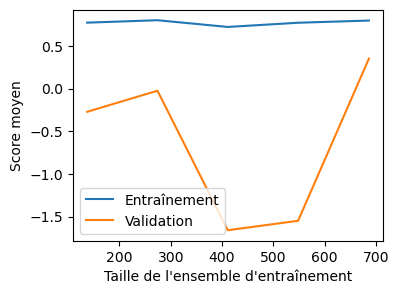

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


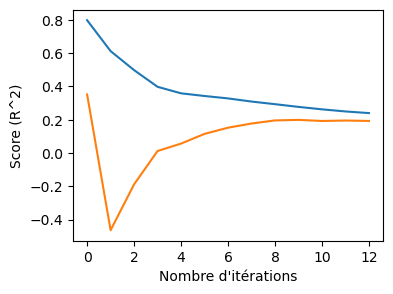

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - MinMaxScaler + TargetEncoder:
 Test score: 0.3530821617196942
 Params: {'regressor__n_neighbors': 2}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
0    {'regressor__n_neighbors': 2}          0.794099         0.353082
12  {'regressor__n_neighbors': 14}          0.234354         0.177770
10  {'regressor__n_neighbors': 12}          0.255707         0.176332
11  {'regressor__n_neighbors': 13}          0.243384         0.176318
9   {'regressor__n_neighbors': 11}          0.268427         0.175578
8   {'regressor__n_neighbors': 10}          0.276130         0.156838
7    {'regressor__n_neighbors': 9}          0.291595         0.140428
6    {'regressor__n_neighbors': 8}          0.310626         0.121808
5    {'regressor__n_neighbors': 7}          0

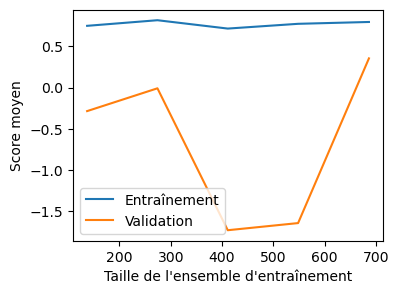

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


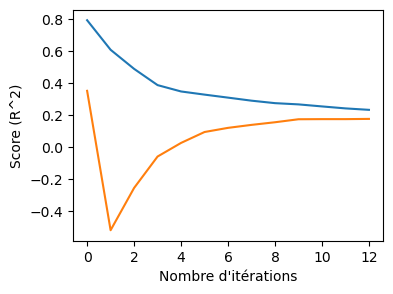

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - PolynomialFeatures + TargetEncoder:
 Test score: -0.07871494324857456
 Params: {'regressor__n_neighbors': 14}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
12  {'regressor__n_neighbors': 14}          0.171865        -0.078715
10  {'regressor__n_neighbors': 12}          0.180403        -0.099375
11  {'regressor__n_neighbors': 13}          0.168768        -0.118991
9   {'regressor__n_neighbors': 11}          0.182509        -0.168000
8   {'regressor__n_neighbors': 10}          0.186164        -0.218768
6    {'regressor__n_neighbors': 8}          0.194876        -0.359221
7    {'regressor__n_neighbors': 9}          0.171937        -0.374190
5    {'regressor__n_neighbors': 7}          0.209694        -0.507805
2    {'regressor__n_neighbors': 4}  

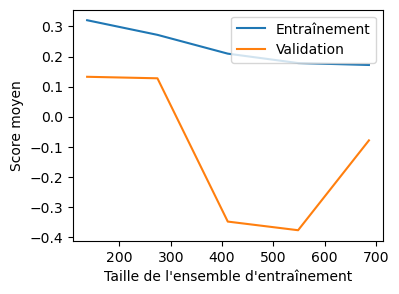

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


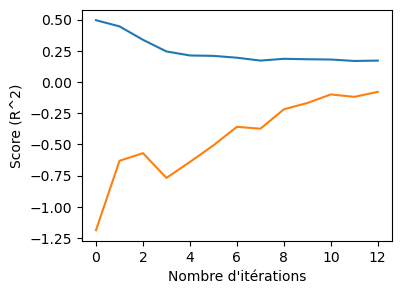

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - RobustScaler + OneHotEncoder:
 Test score: 0.15613883698336067
 Params: {'regressor__alpha': 2.2122654732913327, 'regressor__l1_ratio': 0.3}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
6    {'regressor__alpha': 2.2122654732913327, 'regr...          0.109618   
7    {'regressor__alpha': 2.2122654732913327, 'regr...          0.121428   
0    {'regressor__alpha': 1.0000230261160268, 'regr...          0.131299   
5    {'regressor__alpha': 2.2122654732913327, 'regr...          0.101233   
13   {'regressor__alpha': 4.894005834370745, 'regre...          0.107941   
..                                                 ...               ...   
75   {'regressor__alpha': 148736.86406843894, 'regr...          0.000000 

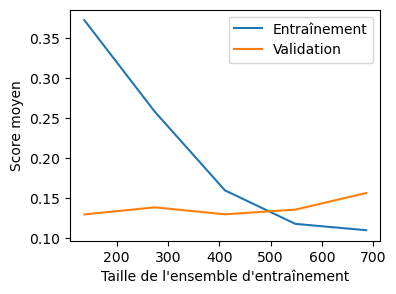

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


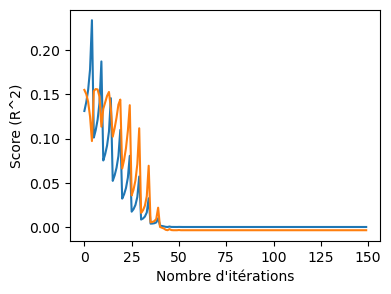

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - StandardScaler + OneHotEncoder:
 Test score: 0.19808013384790918
 Params: {'regressor__alpha': 1.0000230261160268, 'regressor__l1_ratio': 0.7}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
3    {'regressor__alpha': 1.0000230261160268, 'regr...          0.188397   
2    {'regressor__alpha': 1.0000230261160268, 'regr...          0.165687   
9    {'regressor__alpha': 2.2122654732913327, 'regr...          0.196827   
14   {'regressor__alpha': 4.894005834370745, 'regre...          0.156818   
1    {'regressor__alpha': 1.0000230261160268, 'regr...          0.150122   
..                                                 ...               ...   
71   {'regressor__alpha': 67234.37611646035, 'regre...          0.00000

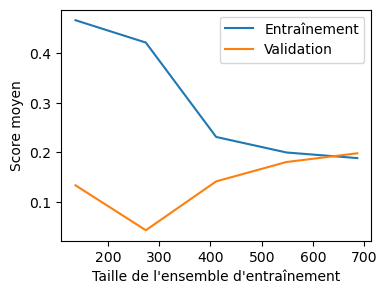

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


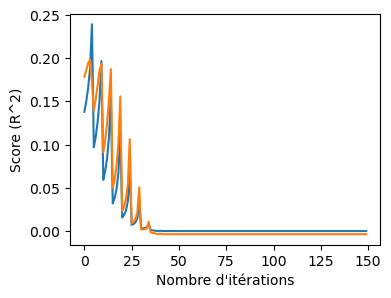

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - MinMaxScaler + OneHotEncoder:
 Test score: 0.12687216005818974
 Params: {'regressor__alpha': 1.0000230261160268, 'regressor__l1_ratio': 0.9}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
4    {'regressor__alpha': 1.0000230261160268, 'regr...          0.131319   
9    {'regressor__alpha': 2.2122654732913327, 'regr...          0.072217   
3    {'regressor__alpha': 1.0000230261160268, 'regr...          0.063349   
2    {'regressor__alpha': 1.0000230261160268, 'regr...          0.043353   
1    {'regressor__alpha': 1.0000230261160268, 'regr...          0.033383   
..                                                 ...               ...   
62   {'regressor__alpha': 13738.423397619588, 'regr...          0.000000 

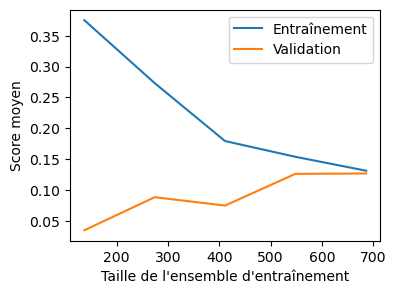

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


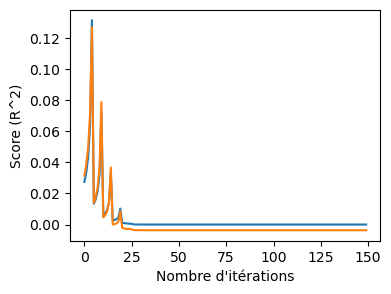

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - PolynomialFeatures + OneHotEncoder:
 Test score: 0.06673416694780232
 Params: {'regressor__alpha': 2043362962.6937475, 'regressor__l1_ratio': 0.3}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
136  {'regressor__alpha': 2043362962.6937475, 'regr...          0.057797   
132  {'regressor__alpha': 923673057.3597437, 'regre...          0.067280   
140  {'regressor__alpha': 4520357245.49924, 'regres...          0.067801   
133  {'regressor__alpha': 923673057.3597437, 'regre...          0.055331   
129  {'regressor__alpha': 417533219.7308553, 'regre...          0.071487   
..                                                 ...               ...   
27   {'regressor__alpha': 52.984178713190175, 'regr...          0.3

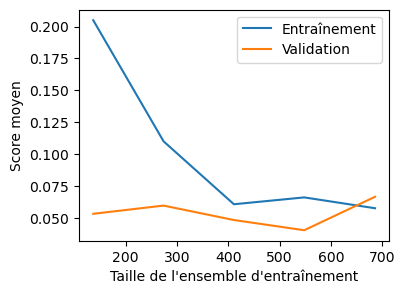

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


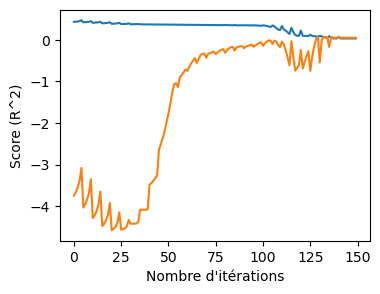

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - RobustScaler + TargetEncoder:
 Test score: 0.10776735915821885
 Params: {'regressor__alpha': 30392.339922466195, 'regressor__l1_ratio': 0.1}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
65  {'regressor__alpha': 30392.339922466195, 'regr...          0.114895   
60  {'regressor__alpha': 13738.423397619588, 'regr...          0.170358   
66  {'regressor__alpha': 30392.339922466195, 'regr...          0.095892   
61  {'regressor__alpha': 13738.423397619588, 'regr...          0.166764   
62  {'regressor__alpha': 13738.423397619588, 'regr...          0.163437   
..                                                ...               ...   
33  {'regressor__alpha': 117.21237025225103, 'regr...          0.281823   
26  {

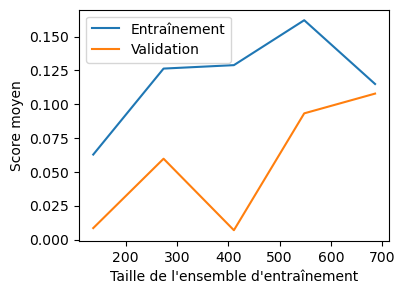

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


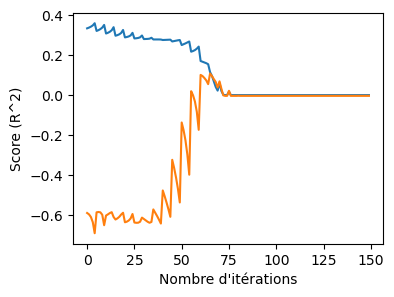

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - StandardScaler + TargetEncoder:
 Test score: 0.10776735915821885
 Params: {'regressor__alpha': 30392.339922466195, 'regressor__l1_ratio': 0.1}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
65  {'regressor__alpha': 30392.339922466195, 'regr...          0.114895   
60  {'regressor__alpha': 13738.423397619588, 'regr...          0.170358   
66  {'regressor__alpha': 30392.339922466195, 'regr...          0.095892   
61  {'regressor__alpha': 13738.423397619588, 'regr...          0.166764   
62  {'regressor__alpha': 13738.423397619588, 'regr...          0.163437   
..                                                ...               ...   
22  {'regressor__alpha': 23.950741614299556, 'regr...          0.286784   
28 

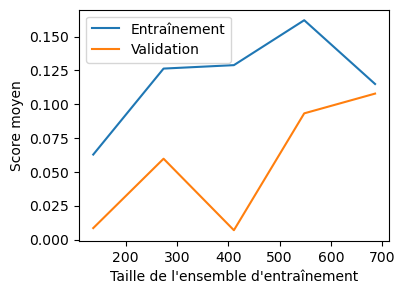

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


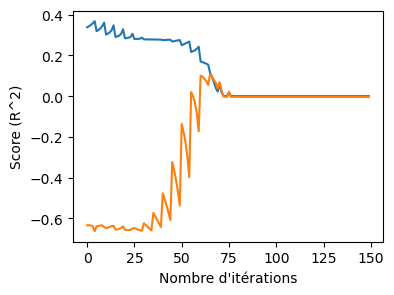

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - MinMaxScaler + TargetEncoder:
 Test score: 0.10776735915821885
 Params: {'regressor__alpha': 30392.339922466195, 'regressor__l1_ratio': 0.1}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
65  {'regressor__alpha': 30392.339922466195, 'regr...          0.114895   
60  {'regressor__alpha': 13738.423397619588, 'regr...          0.170358   
66  {'regressor__alpha': 30392.339922466195, 'regr...          0.095892   
61  {'regressor__alpha': 13738.423397619588, 'regr...          0.166764   
62  {'regressor__alpha': 13738.423397619588, 'regr...          0.163437   
..                                                ...               ...   
11  {'regressor__alpha': 4.894005834370745, 'regre...          0.278044   
12  {

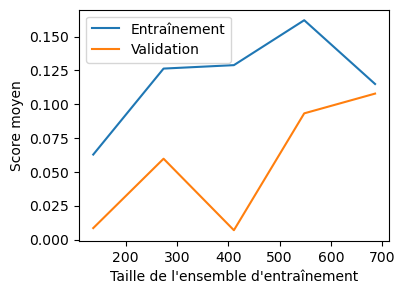

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


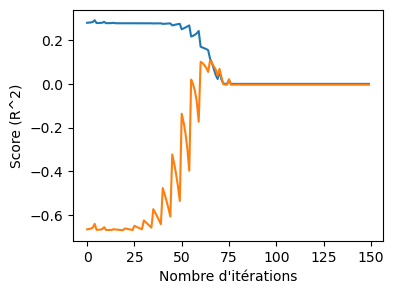

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - PolynomialFeatures + TargetEncoder:
 Test score: 0.06673416694780232
 Params: {'regressor__alpha': 2043362962.6937475, 'regressor__l1_ratio': 0.3}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
136  {'regressor__alpha': 2043362962.6937475, 'regr...          0.057797   
132  {'regressor__alpha': 923673057.3597437, 'regre...          0.067280   
140  {'regressor__alpha': 4520357245.49924, 'regres...          0.067801   
133  {'regressor__alpha': 923673057.3597437, 'regre...          0.055331   
129  {'regressor__alpha': 417533219.7308553, 'regre...          0.071487   
..                                                 ...               ...   
27   {'regressor__alpha': 52.984178713190175, 'regr...          0.5

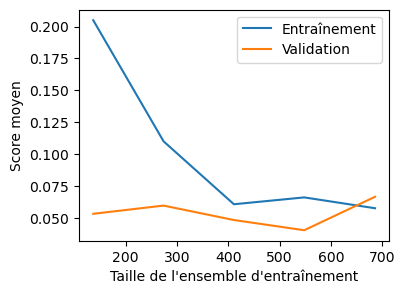

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


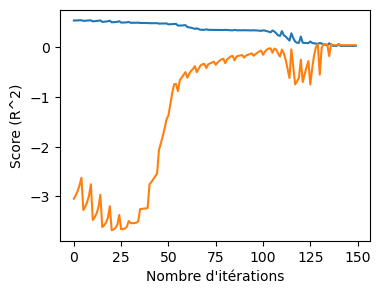

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - RobustScaler + OneHotEncoder:
 Test score: 0.4886309069553795
 Params: {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 198}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
74   {'regressor__learning_rate': 0.25, 'regressor_...          0.998637   
89   {'regressor__learning_rate': 0.25, 'regressor_...          0.999759   
81   {'regressor__learning_rate': 0.25, 'regressor_...          0.999411   
87   {'regressor__learning_rate': 0.25, 'regressor_...          0.999701   
76   {'regressor__learning_rate': 0.25, 'regressor_...          0.998952   
..                                                 ...               ...   
120  {'regressor__learning_rate': 0.05, 'regressor_.

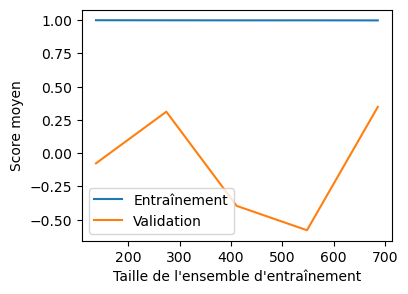

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


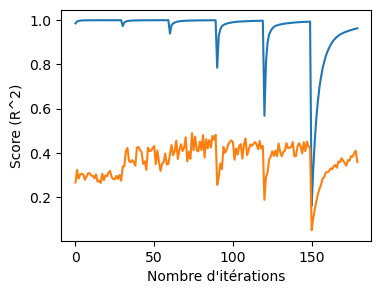

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - StandardScaler + OneHotEncoder:
 Test score: 0.48982512662811273
 Params: {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 400}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
89   {'regressor__learning_rate': 0.25, 'regressor_...          0.999759   
80   {'regressor__learning_rate': 0.25, 'regressor_...          0.999330   
115  {'regressor__learning_rate': 0.1, 'regressor__...          0.997183   
76   {'regressor__learning_rate': 0.25, 'regressor_...          0.998952   
87   {'regressor__learning_rate': 0.25, 'regressor_...          0.999701   
..                                                 ...               ...   
153  {'regressor__learning_rate': 0.01, 'regresso

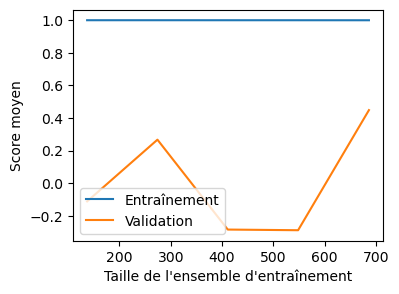

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


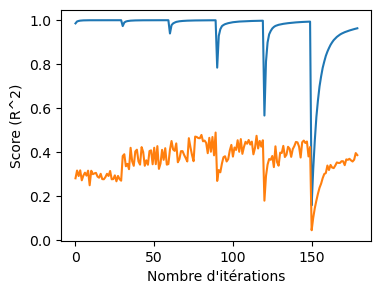

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - MinMaxScaler + OneHotEncoder:
 Test score: 0.4898079017779177
 Params: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 171}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
102  {'regressor__learning_rate': 0.1, 'regressor__...          0.992709   
78   {'regressor__learning_rate': 0.25, 'regressor_...          0.999170   
68   {'regressor__learning_rate': 0.25, 'regressor_...          0.996686   
75   {'regressor__learning_rate': 0.25, 'regressor_...          0.998798   
147  {'regressor__learning_rate': 0.05, 'regressor_...          0.993135   
..                                                 ...               ...   
120  {'regressor__learning_rate': 0.05, 'regressor_..

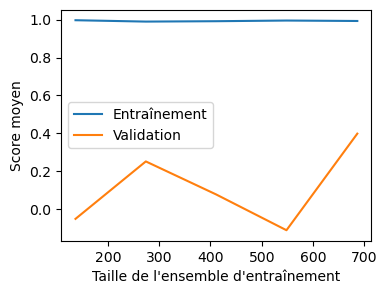

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


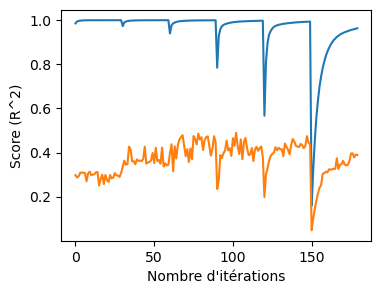

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - PolynomialFeatures + OneHotEncoder:
 Test score: 0.37804402072790194
 Params: {'regressor__learning_rate': 0.5, 'regressor__n_estimators': 386}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
58   {'regressor__learning_rate': 0.5, 'regressor__...          0.999999   
66   {'regressor__learning_rate': 0.25, 'regressor_...          0.996999   
43   {'regressor__learning_rate': 0.5, 'regressor__...          0.999927   
102  {'regressor__learning_rate': 0.1, 'regressor__...          0.995326   
128  {'regressor__learning_rate': 0.05, 'regressor_...          0.980576   
..                                                 ...               ...   
26   {'regressor__learning_rate': 1, 'regresso

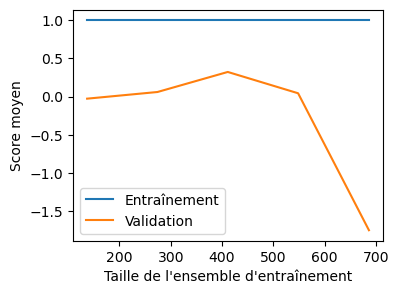

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


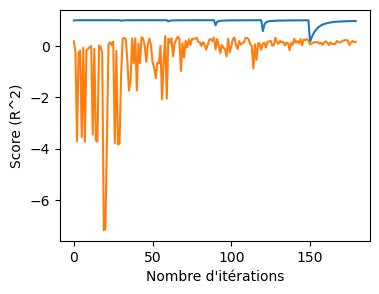

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - RobustScaler + TargetEncoder:
 Test score: 0.5285747421339091
 Params: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 225}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
106  {'regressor__learning_rate': 0.1, 'regressor__...          0.995302   
118  {'regressor__learning_rate': 0.1, 'regressor__...          0.997837   
110  {'regressor__learning_rate': 0.1, 'regressor__...          0.996487   
74   {'regressor__learning_rate': 0.25, 'regressor_...          0.998730   
148  {'regressor__learning_rate': 0.05, 'regressor_...          0.994205   
..                                                 ...               ...   
10   {'regressor__learning_rate': 1, 'regressor__n_..

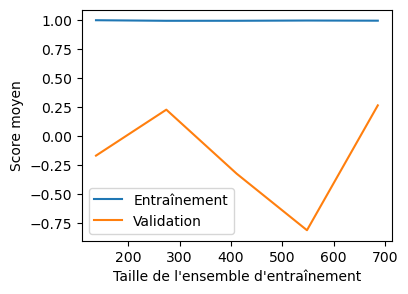

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


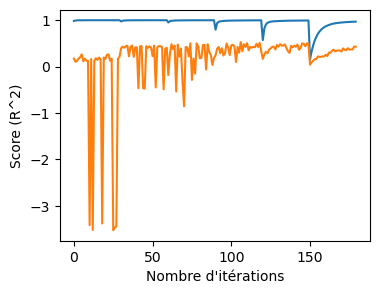

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - StandardScaler + TargetEncoder:
 Test score: 0.5091402255700304
 Params: {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 319}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
83   {'regressor__learning_rate': 0.25, 'regressor_...          0.999573   
103  {'regressor__learning_rate': 0.1, 'regressor__...          0.993999   
141  {'regressor__learning_rate': 0.05, 'regressor_...          0.991910   
146  {'regressor__learning_rate': 0.05, 'regressor_...          0.993678   
139  {'regressor__learning_rate': 0.05, 'regressor_...          0.991054   
..                                                 ...               ...   
49   {'regressor__learning_rate': 0.5, 'regressor_

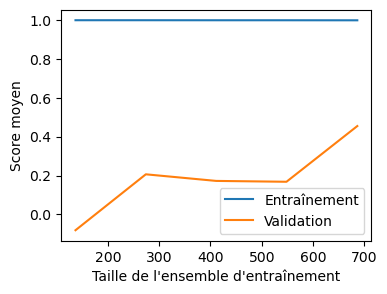

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


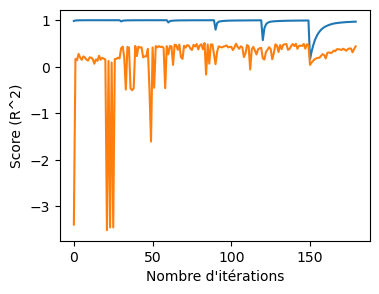

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - MinMaxScaler + TargetEncoder:
 Test score: 0.5229046715725287
 Params: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 238}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
107  {'regressor__learning_rate': 0.1, 'regressor__...          0.995648   
111  {'regressor__learning_rate': 0.1, 'regressor__...          0.996685   
133  {'regressor__learning_rate': 0.05, 'regressor_...          0.986646   
134  {'regressor__learning_rate': 0.05, 'regressor_...          0.987677   
64   {'regressor__learning_rate': 0.25, 'regressor_...          0.993023   
..                                                 ...               ...   
6    {'regressor__learning_rate': 1, 'regressor__n_..

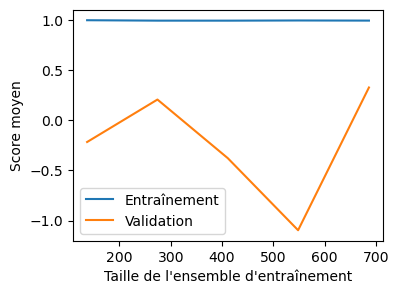

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


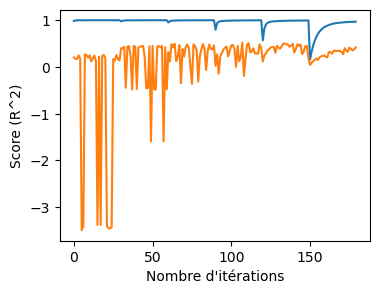

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - PolynomialFeatures + TargetEncoder:
 Test score: 0.5171816129393968
 Params: {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 171}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
72  {'regressor__learning_rate': 0.25, 'regressor_...          0.999236   
80  {'regressor__learning_rate': 0.25, 'regressor_...          0.999806   
98  {'regressor__learning_rate': 0.1, 'regressor__...          0.993001   
69  {'regressor__learning_rate': 0.25, 'regressor_...          0.998658   
52  {'regressor__learning_rate': 0.5, 'regressor__...          0.999996   
..                                                ...               ...   
10  {'regressor__learning_rate': 1, 'regressor__n_...

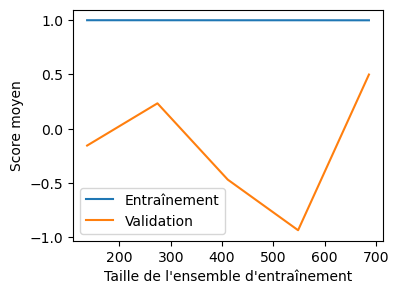

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


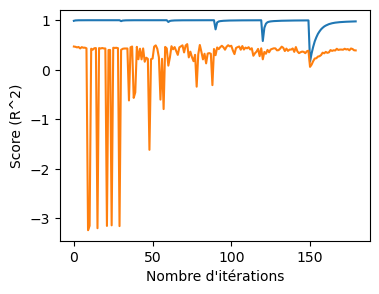

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - RobustScaler + OneHotEncoder:
 Test score: 0.28214932936289394
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.293348         0.282149
4   {'regressor__C': 100.0}          0.123839         0.181047
3    {'regressor__C': 10.0}          0.043968         0.077026
2     {'regressor__C': 1.0}         -0.009923        -0.021352
1     {'regressor__C': 0.1}         -0.030260        -0.062059
0    {'regressor__C': 0.01}         -0.032597        -0.066884
--------------------------------
| Courbe d'apprentissage |
--------------------------------


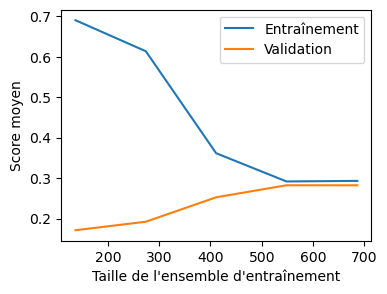

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


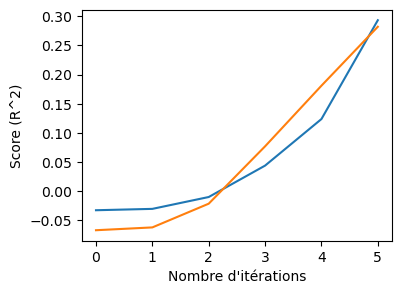

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - StandardScaler + OneHotEncoder:
 Test score: 0.27945525121026094
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.292960         0.279455
4   {'regressor__C': 100.0}          0.111745         0.172779
3    {'regressor__C': 10.0}          0.022079         0.038707
2     {'regressor__C': 1.0}         -0.021048        -0.042421
1     {'regressor__C': 0.1}         -0.031442        -0.064703
0    {'regressor__C': 0.01}         -0.032732        -0.067120
--------------------------------
| Courbe d'apprentissage |
--------------------------------


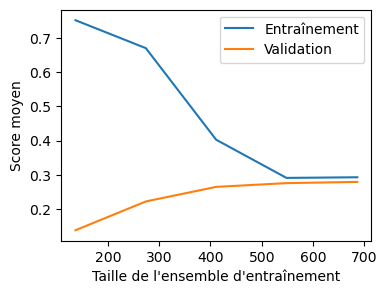

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


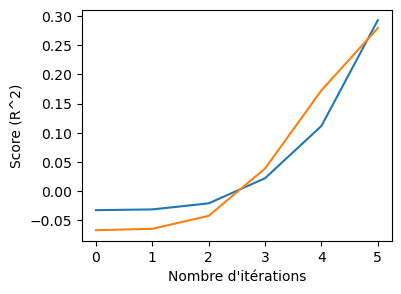

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - MinMaxScaler + OneHotEncoder:
 Test score: 0.313906564606926
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.243366         0.313907
4   {'regressor__C': 100.0}          0.058884         0.095307
3    {'regressor__C': 10.0}          0.001382         0.004056
2     {'regressor__C': 1.0}         -0.026344        -0.051317
1     {'regressor__C': 0.1}         -0.032258        -0.065816
0    {'regressor__C': 0.01}         -0.032789        -0.067129
--------------------------------
| Courbe d'apprentissage |
--------------------------------


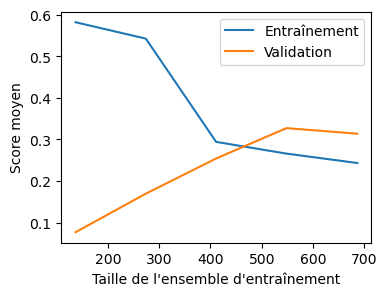

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


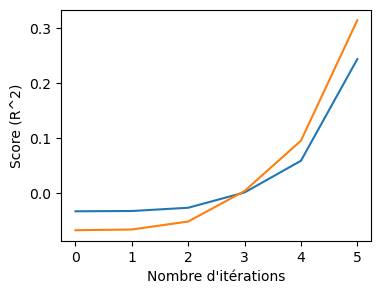

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - PolynomialFeatures + OneHotEncoder:
 Test score: 0.10499419109520829
 Params: {'regressor__C': 100.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
4   {'regressor__C': 100.0}          0.061080         0.104994
5  {'regressor__C': 1000.0}          0.057850         0.085822
3    {'regressor__C': 10.0}          0.028002         0.045469
2     {'regressor__C': 1.0}         -0.015151        -0.034245
1     {'regressor__C': 0.1}         -0.030957        -0.064044
0    {'regressor__C': 0.01}         -0.032675        -0.067038
--------------------------------
| Courbe d'apprentissage |
--------------------------------


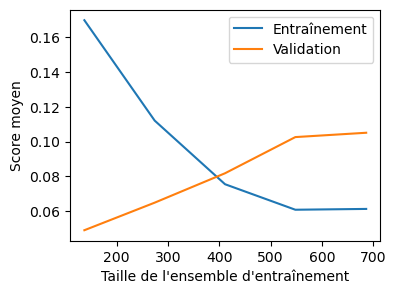

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


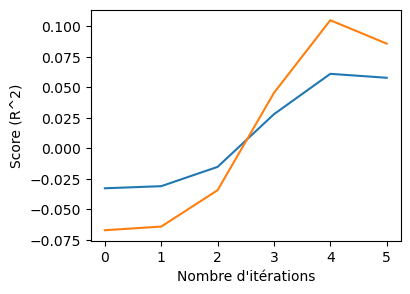

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - RobustScaler + TargetEncoder:
 Test score: 0.21143029258615842
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.271152         0.211430
4   {'regressor__C': 100.0}          0.077721         0.089260
3    {'regressor__C': 10.0}          0.014921         0.023331
2     {'regressor__C': 1.0}         -0.012344        -0.027656
1     {'regressor__C': 0.1}         -0.030108        -0.061416
0    {'regressor__C': 0.01}         -0.032529        -0.066723
--------------------------------
| Courbe d'apprentissage |
--------------------------------


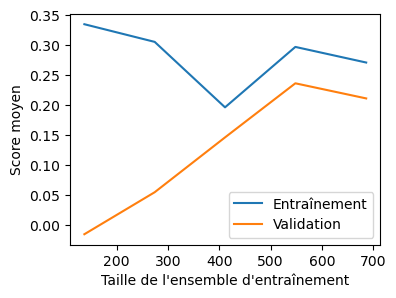

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


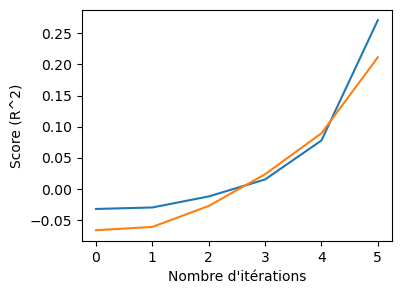

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - StandardScaler + TargetEncoder:
 Test score: 0.1973183325277182
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.267057         0.197318
4   {'regressor__C': 100.0}          0.077067         0.087304
3    {'regressor__C': 10.0}          0.014847         0.023215
2     {'regressor__C': 1.0}         -0.012366        -0.027701
1     {'regressor__C': 0.1}         -0.030111        -0.061423
0    {'regressor__C': 0.01}         -0.032529        -0.066724
--------------------------------
| Courbe d'apprentissage |
--------------------------------


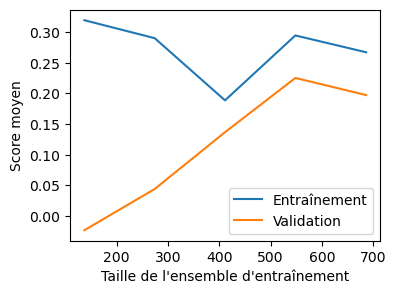

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


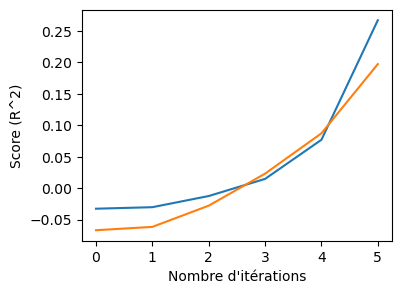

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - MinMaxScaler + TargetEncoder:
 Test score: 0.19118816032919378
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.265203         0.191188
4   {'regressor__C': 100.0}          0.076885         0.086818
3    {'regressor__C': 10.0}          0.014834         0.023178
2     {'regressor__C': 1.0}         -0.012356        -0.027690
1     {'regressor__C': 0.1}         -0.030108        -0.061415
0    {'regressor__C': 0.01}         -0.032529        -0.066723
--------------------------------
| Courbe d'apprentissage |
--------------------------------


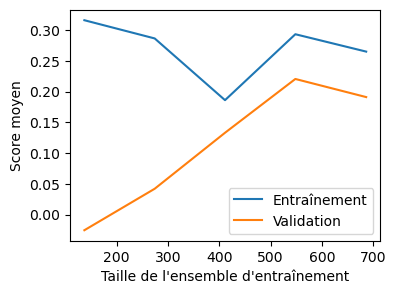

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


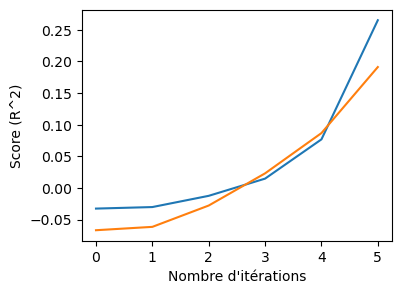

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - PolynomialFeatures + TargetEncoder:
 Test score: 0.10498163218228848
 Params: {'regressor__C': 100.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
4   {'regressor__C': 100.0}          0.061070         0.104982
5  {'regressor__C': 1000.0}          0.057864         0.085827
3    {'regressor__C': 10.0}          0.028001         0.045468
2     {'regressor__C': 1.0}         -0.015148        -0.034241
1     {'regressor__C': 0.1}         -0.030957        -0.064043
0    {'regressor__C': 0.01}         -0.032675        -0.067038
--------------------------------
| Courbe d'apprentissage |
--------------------------------


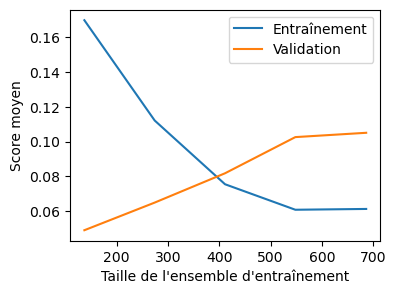

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


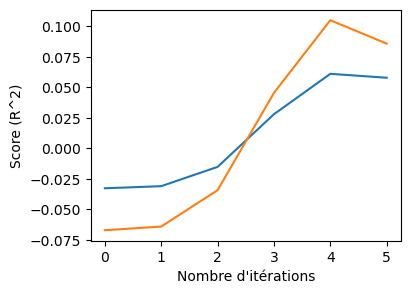

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - RobustScaler + OneHotEncoder:
 Test score: 0.3340970121931268
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 50}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
24  {'regressor__min_samples_leaf': 4, 'regressor_...          0.478156   
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.477215   
33  {'regressor__min_samples_leaf': 4, 'regressor_...          0.477335   
39  {'regressor__min_samples_leaf': 4, 'regressor_...          0.480325   
16  {'regressor__min_samples_leaf': 1, 'regressor_...          0.884396   
23  {'regressor__min_samples_leaf': 4, 'regressor_...          0.472793   
0   {'regressor__min_samples_leaf': 1, 'regressor_...          0.808028   
22

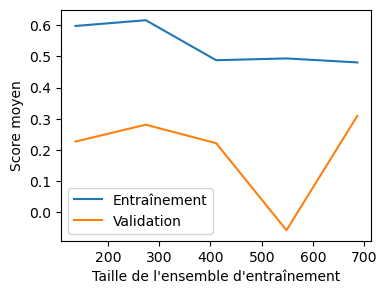

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


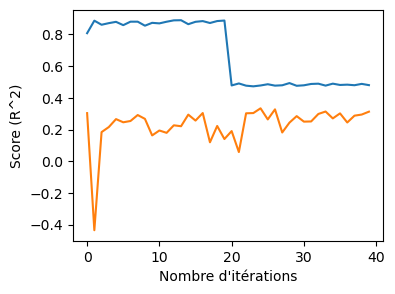

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - StandardScaler + OneHotEncoder:
 Test score: 0.36732823016910243
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 60}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.480429   
22  {'regressor__min_samples_leaf': 4, 'regressor_...          0.473738   
9   {'regressor__min_samples_leaf': 1, 'regressor_...          0.862869   
36  {'regressor__min_samples_leaf': 4, 'regressor_...          0.488924   
34  {'regressor__min_samples_leaf': 4, 'regressor_...          0.485860   
32  {'regressor__min_samples_leaf': 4, 'regressor_...          0.486542   
7   {'regressor__min_samples_leaf': 1, 'regressor_...          0.881237   

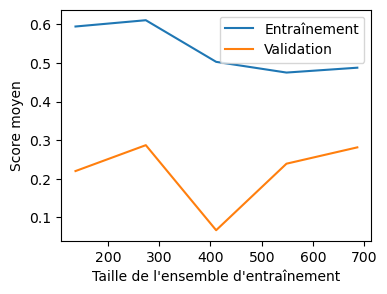

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


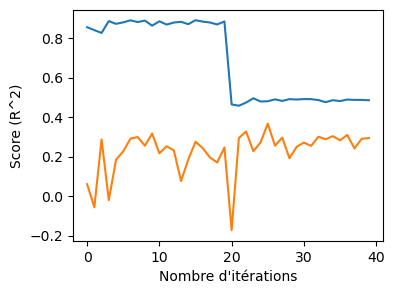

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - MinMaxScaler + OneHotEncoder:
 Test score: 0.3803568467504652
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 20}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
21  {'regressor__min_samples_leaf': 4, 'regressor_...          0.487317   
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.476883   
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.480551   
33  {'regressor__min_samples_leaf': 4, 'regressor_...          0.483161   
12  {'regressor__min_samples_leaf': 1, 'regressor_...          0.881182   
38  {'regressor__min_samples_leaf': 4, 'regressor_...          0.481929   
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.484034   
1 

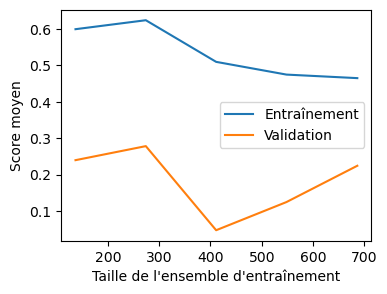

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


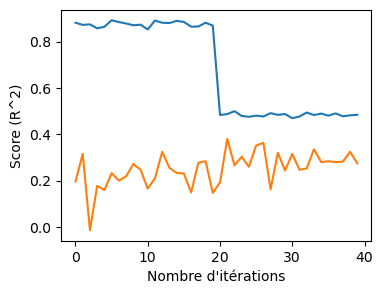

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - PolynomialFeatures + OneHotEncoder:
 Test score: 0.3330541987211525
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 130}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
32  {'regressor__min_samples_leaf': 4, 'regressor_...          0.517059   
30  {'regressor__min_samples_leaf': 4, 'regressor_...          0.511226   
31  {'regressor__min_samples_leaf': 4, 'regressor_...          0.499564   
35  {'regressor__min_samples_leaf': 4, 'regressor_...          0.518934   
20  {'regressor__min_samples_leaf': 4, 'regressor_...          0.495468   
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.516151   
22  {'regressor__min_samples_leaf': 4, 'regressor_...          0.50831

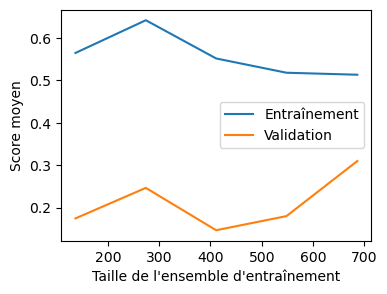

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


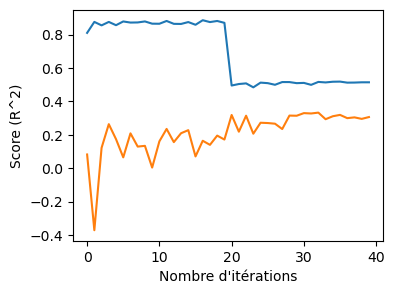

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - RobustScaler + TargetEncoder:
 Test score: 0.45926660999448304
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
22  {'regressor__min_samples_leaf': 4, 'regressor_...          0.480252   
23  {'regressor__min_samples_leaf': 4, 'regressor_...          0.493640   
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.503411   
32  {'regressor__min_samples_leaf': 4, 'regressor_...          0.503490   
34  {'regressor__min_samples_leaf': 4, 'regressor_...          0.509987   
38  {'regressor__min_samples_leaf': 4, 'regressor_...          0.511516   
36  {'regressor__min_samples_leaf': 4, 'regressor_...          0.510166   
2

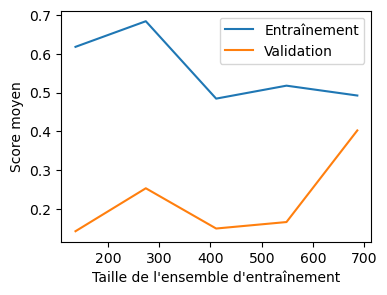

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


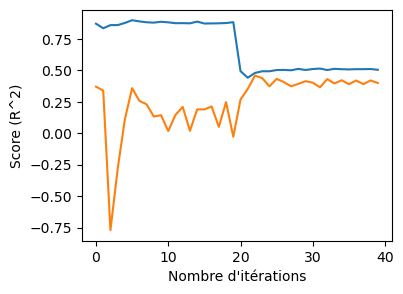

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - StandardScaler + TargetEncoder:
 Test score: 0.44536753382654204
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 30}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
22  {'regressor__min_samples_leaf': 4, 'regressor_...          0.503217   
30  {'regressor__min_samples_leaf': 4, 'regressor_...          0.485630   
35  {'regressor__min_samples_leaf': 4, 'regressor_...          0.514286   
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.505369   
32  {'regressor__min_samples_leaf': 4, 'regressor_...          0.507106   
38  {'regressor__min_samples_leaf': 4, 'regressor_...          0.511706   
37  {'regressor__min_samples_leaf': 4, 'regressor_...          0.506705   

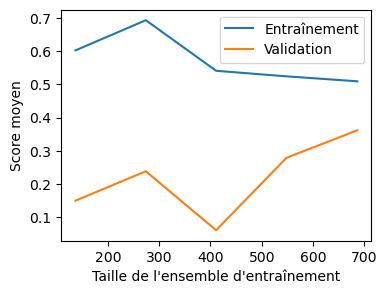

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


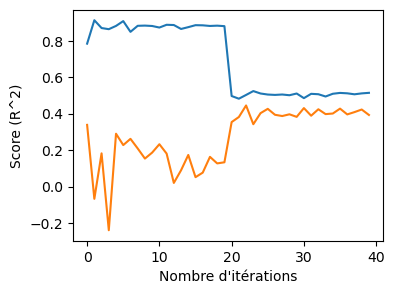

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - MinMaxScaler + TargetEncoder:
 Test score: 0.45360021647471427
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 80}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
27  {'regressor__min_samples_leaf': 4, 'regressor_...          0.494719   
30  {'regressor__min_samples_leaf': 4, 'regressor_...          0.512641   
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.512730   
38  {'regressor__min_samples_leaf': 4, 'regressor_...          0.501411   
33  {'regressor__min_samples_leaf': 4, 'regressor_...          0.510809   
36  {'regressor__min_samples_leaf': 4, 'regressor_...          0.511410   
24  {'regressor__min_samples_leaf': 4, 'regressor_...          0.517472   
3

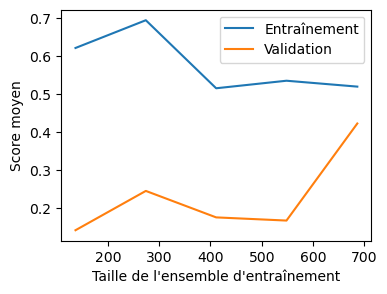

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


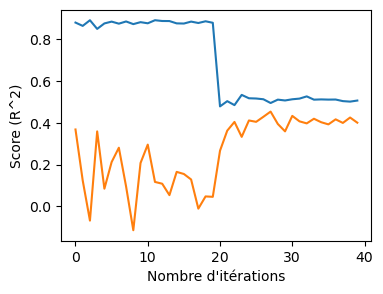

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - PolynomialFeatures + TargetEncoder:
 Test score: 0.49023540219254425
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 90}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.555513   
23  {'regressor__min_samples_leaf': 4, 'regressor_...          0.539325   
35  {'regressor__min_samples_leaf': 4, 'regressor_...          0.553323   
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.539737   
24  {'regressor__min_samples_leaf': 4, 'regressor_...          0.542111   
39  {'regressor__min_samples_leaf': 4, 'regressor_...          0.539310   
36  {'regressor__min_samples_leaf': 4, 'regressor_...          0.55811

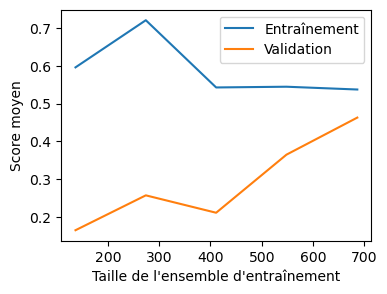

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


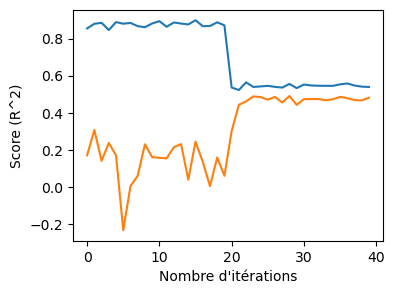

In [21]:
# Utilisation de la fonction run_models_with_preprocessors()
models_wth_energy_star = run_models_with_preprocessors(models, preprocessor_configs, grid_configs, X_train, y_train, X_test, y_test, numeric_features, categorical_features)

# Selection naif des model les plus performant

In [27]:
selected_models = []

for result_key, result_info in models_wth_energy_star.items():
    test_score = result_info["Test score"]
    
    if test_score > 0.50:
        selected_models.append((result_key, result_info["Params"], test_score))

print_titre("Les modèles ayant un score de test supérieur à 0.50 sont :")

for model, config, test_score in selected_models:
    print(f"Nom du modèle : {model}\nConfiguration : {config}\nTest Score : {test_score}")

--------------------------------------------------------------------
| Les modèles ayant un score de test supérieur à 0.50 sont : |
--------------------------------------------------------------------
Nom du modèle : GradientBoosting - RobustScaler + TargetEncoder
Configuration : {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 225}
Test Score : 0.5285747421339091
Nom du modèle : GradientBoosting - StandardScaler + TargetEncoder
Configuration : {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 319}
Test Score : 0.5091402255700304
Nom du modèle : GradientBoosting - MinMaxScaler + TargetEncoder
Configuration : {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 238}
Test Score : 0.5229046715725287
Nom du modèle : GradientBoosting - PolynomialFeatures + TargetEncoder
Configuration : {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 171}
Test Score : 0.5171816129393968


# Model GradientBoostingRegressor

In [28]:
# Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", RobustScaler(), numeric_features),
        ("cat", TargetEncoder(cols=categorical_features), categorical_features),
    ]
)

# Model GradientBoostingRegressor
pipeline_gb = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", GradientBoostingRegressor())]
)

# GridSearchCV pour GradientBoostingRegressor
grid_gb = {
    'regressor__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
    'regressor__n_estimators': np.linspace(10, 400, 30, dtype=int)
}


cv_gb = train_model(pipeline_gb, grid_gb, X_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


# Analyse de l'importance des variables

In [29]:
!pip install shap
import shap
shap.initjs()

La valeur de Shapley, dans le context de l'interpretation de modèles d'apprentissage automatique, permet d'évaluer l'inpact de chaque caractérisqtique sur une prédiction donnée.
**Elle fait cela en calculant la contibution moyenne de chaque caractéristique à la prédiction sur toutes les combinaisons possible de caractéristiques.**


# Standard SHAP values 

In [30]:
best_model = cv_gb.best_estimator_

In [31]:
final_model = cv_gb.best_estimator_.named_steps['regressor']

In [32]:
# Créer un explainer pour le modèle final avec les noms de fonctionnalités
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
explainer = shap.Explainer(final_model, feature_names=feature_names)

In [33]:
X_test_preprocessed = cv_gb.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [34]:
shap_values = explainer.shap_values(X_test_preprocessed)

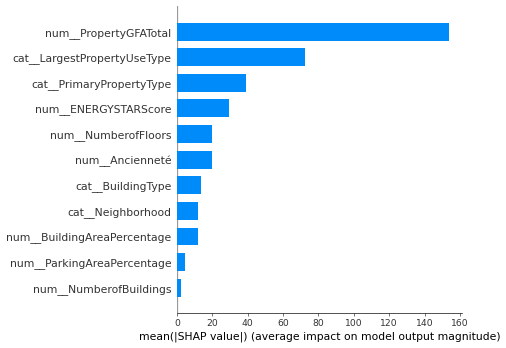

In [35]:
plt.figure(figsize=(10, 6), dpi=60)
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar")


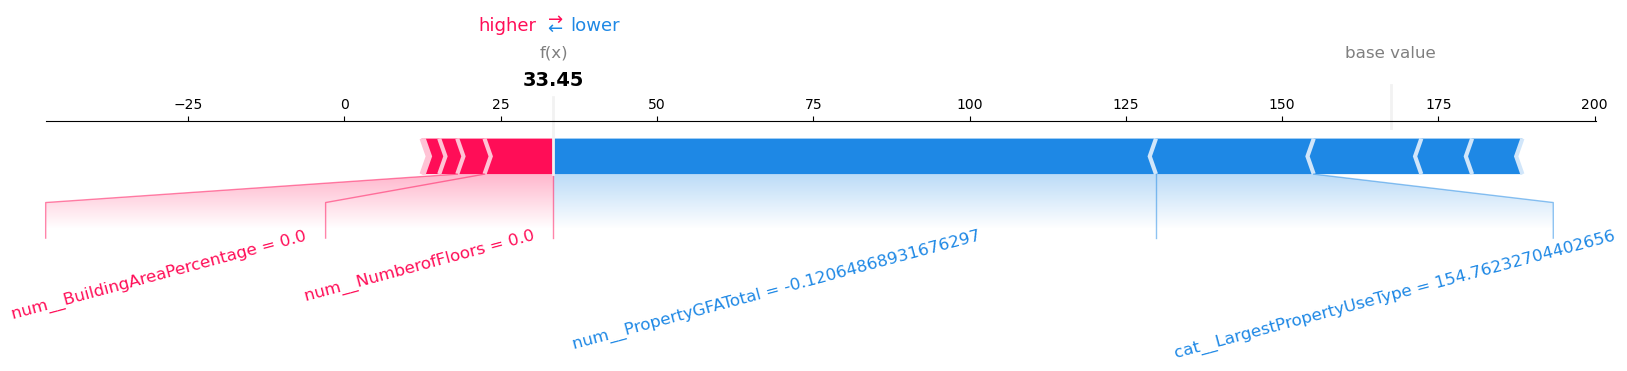

In [37]:
# Représentation de l'effet des variables sur un bâtiment
shap.initjs()
i = 80
shap_values_i = explainer.shap_values(X_test_preprocessed[i].reshape(1, -1))
shap.force_plot(explainer.expected_value, shap_values_i, X_test_preprocessed[i], show=True, matplotlib=True, text_rotation=15, feature_names=feature_names)

# Model final

----------------------------------------------------------------------------------------------------
# | Les modèles ayant un score de test supérieur à 0.50 sont : |
----------------------------------------------------------------------------------------------------

```py
Nom du modèle : GradientBoosting - RobustScaler + TargetEncoder
Configuration : {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 225}
Test Score : 0.5285747421339091
Nom du modèle : GradientBoosting - StandardScaler + TargetEncoder
Configuration : {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 319}
Test Score : 0.5091402255700304
Nom du modèle : GradientBoosting - MinMaxScaler + TargetEncoder
Configuration : {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 238}
Test Score : 0.5229046715725287
Nom du modèle : GradientBoosting - PolynomialFeatures + TargetEncoder
Configuration : {'regressor__learning_rate': 0.25, 'regressor__n_estimators': 171}
Test Score : 0.5171816129393968
```

----------------------------------------------------------------------------------------------------
# | Model final : |
----------------------------------------------------------------------------------------------------
```py
Nom du modèle : GradientBoosting - RobustScaler + TargetEncoder
Configuration : {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 225}
Test Score : 0.5285747421339091
```

In [38]:
# Diviser les données
X = energy_benchmarking_ml.dropna().drop(columns=['TotalGHGEmissions'])
y = energy_benchmarking_ml.dropna()['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40)

best_model = GradientBoostingRegressor(learning_rate=0.1, n_estimators=225, random_state=40)

pipeline = Pipeline(
    steps=[("preprocessor", preprocessor), ("regressor", best_model)]
)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', RobustScaler(),
                                                  ['Ancienneté',
                                                   'BuildingAreaPercentage',
                                                   'ParkingAreaPercentage',
                                                   'NumberofBuildings',
                                                   'NumberofFloors',
                                                   'PropertyGFATotal',
                                                   'ENERGYSTARScore']),
                                                 ('cat',
                                                  TargetEncoder(cols=['Neighborhood',
                                                                      'PrimaryPropertyType',
                                                                      'BuildingType',
                                                                      

In [39]:
# Entraîner la pipeline sur l'ensemble d'entraînement
pipeline.fit(X_train, y_train)

# Prédire avec le modèle sur l'ensemble de test
y_pred = pipeline.predict(X_test)

In [40]:
print("R² (Test Set) :", r2_score(y_test, y_pred))
print("MSE (Test Set) :" , mean_squared_error(y_test, y_pred,squared=False).round(2))
print("RMSE (Test Set) :", mean_squared_error(y_test, y_pred).round(2))
print("MAE (Test Set) :", mean_absolute_error(y_test, y_pred).round(2))

R² (Test Set) : 0.6649790735254058
MSE (Test Set) : 717.88
RMSE (Test Set) : 515354.65
MAE (Test Set) : 146.61


# Analyse Comparative sans la variable `ENERGYSTARScore `

In [41]:
numeric_features = ['Ancienneté', 'BuildingAreaPercentage', 'ParkingAreaPercentage',
                     'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal']

categorical_features = ['Neighborhood', 'PrimaryPropertyType', 'BuildingType', 'LargestPropertyUseType']

In [42]:
energy_benchmarking_ml = energy_benchmarking_ml[numeric_features + categorical_features + ['TotalGHGEmissions']]

In [43]:
energy_benchmarking_ml.columns

Index(['Ancienneté', 'BuildingAreaPercentage', 'ParkingAreaPercentage',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'Neighborhood', 'PrimaryPropertyType', 'BuildingType',
       'LargestPropertyUseType', 'TotalGHGEmissions'],
      dtype='object')

In [44]:
# Sélectionner les 1073 premières lignes
energy_benchmarking_ml_subset = energy_benchmarking_ml.iloc[:1073]

In [45]:
energy_benchmarking_ml_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Ancienneté              1073 non-null   int64  
 1   BuildingAreaPercentage  1073 non-null   float64
 2   ParkingAreaPercentage   1073 non-null   float64
 3   NumberofBuildings       1073 non-null   float64
 4   NumberofFloors          1073 non-null   int64  
 5   PropertyGFATotal        1073 non-null   int64  
 6   Neighborhood            1073 non-null   object 
 7   PrimaryPropertyType     1073 non-null   object 
 8   BuildingType            1073 non-null   object 
 9   LargestPropertyUseType  1073 non-null   object 
 10  TotalGHGEmissions       1073 non-null   float64
dtypes: float64(4), int64(3), object(4)
memory usage: 92.3+ KB


In [46]:
# Diviser les données
X = energy_benchmarking_ml_subset.dropna().drop(columns=['TotalGHGEmissions'])
y = energy_benchmarking_ml_subset.dropna()['TotalGHGEmissions']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=41)

In [47]:
# Utilisation de la fonction run_models_with_preprocessors()
preprocessor_configs = [
    ("RobustScaler + OneHotEncoder", RobustScaler(), OneHotEncoder(handle_unknown='ignore')),
    ("StandardScaler + OneHotEncoder", StandardScaler(), OneHotEncoder(handle_unknown='ignore')),
    ("MinMaxScaler + OneHotEncoder", MinMaxScaler(), OneHotEncoder(handle_unknown='ignore')),
    ("PolynomialFeatures + OneHotEncoder", PolynomialFeatures(), OneHotEncoder(handle_unknown='ignore')),
    ("RobustScaler + TargetEncoder", RobustScaler(), TargetEncoder(cols=categorical_features)),
    ("StandardScaler + TargetEncoder", StandardScaler(), TargetEncoder(cols=categorical_features)),
    ("MinMaxScaler + TargetEncoder", MinMaxScaler(), TargetEncoder(cols=categorical_features)),
    ("PolynomialFeatures + TargetEncoder", PolynomialFeatures(), TargetEncoder(cols=categorical_features)),
]

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - RobustScaler + OneHotEncoder:
 Test score: 0.3250781344658666
 Params: {'regressor__n_neighbors': 13}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
11  {'regressor__n_neighbors': 13}          0.348275         0.325078
12  {'regressor__n_neighbors': 14}          0.333994         0.322327
10  {'regressor__n_neighbors': 12}          0.363308         0.317699
9   {'regressor__n_neighbors': 11}          0.375685         0.297187
7    {'regressor__n_neighbors': 9}          0.414194         0.252981
5    {'regressor__n_neighbors': 7}          0.474127         0.250870
8   {'regressor__n_neighbors': 10}          0.399239         0.239339
6    {'regressor__n_neighbors': 8}          0.441135         0.226420
3    {'regressor__n_neighbors': 5}          

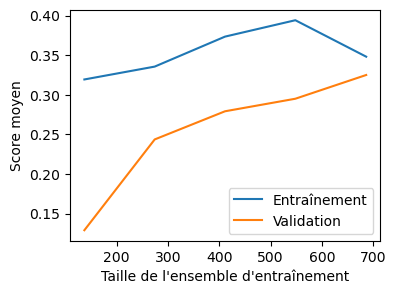

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


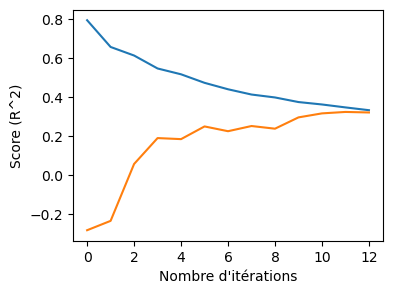

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - StandardScaler + OneHotEncoder:
 Test score: 0.24942453871380055
 Params: {'regressor__n_neighbors': 14}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
12  {'regressor__n_neighbors': 14}          0.331656         0.249425
11  {'regressor__n_neighbors': 13}          0.343625         0.247772
10  {'regressor__n_neighbors': 12}          0.361860         0.232731
9   {'regressor__n_neighbors': 11}          0.378658         0.219141
8   {'regressor__n_neighbors': 10}          0.400039         0.193351
4    {'regressor__n_neighbors': 6}          0.544042         0.186978
7    {'regressor__n_neighbors': 9}          0.423631         0.145069
6    {'regressor__n_neighbors': 8}          0.459497         0.121721
3    {'regressor__n_neighbors': 5}       

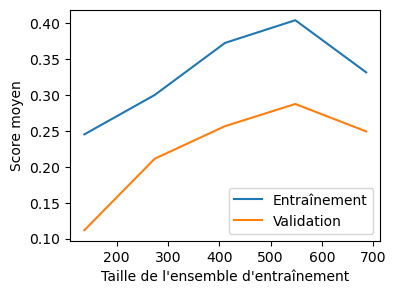

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


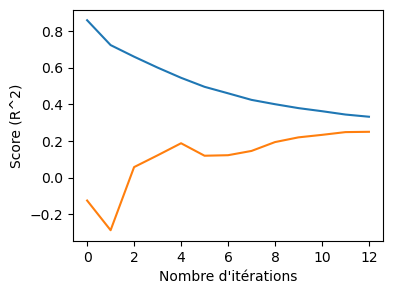

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - MinMaxScaler + OneHotEncoder:
 Test score: 0.3463368266311603
 Params: {'regressor__n_neighbors': 10}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
8   {'regressor__n_neighbors': 10}          0.395156         0.346337
7    {'regressor__n_neighbors': 9}          0.424830         0.343386
5    {'regressor__n_neighbors': 7}          0.496880         0.342530
6    {'regressor__n_neighbors': 8}          0.456676         0.329028
10  {'regressor__n_neighbors': 12}          0.345646         0.323977
11  {'regressor__n_neighbors': 13}          0.323407         0.322239
9   {'regressor__n_neighbors': 11}          0.369578         0.316192
12  {'regressor__n_neighbors': 14}          0.303535         0.315009
4    {'regressor__n_neighbors': 6}          

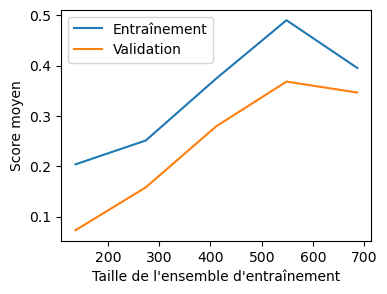

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


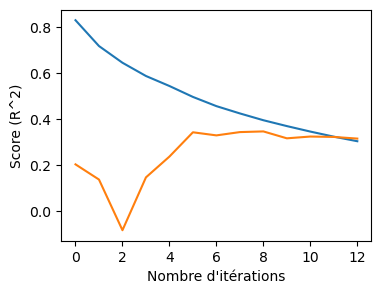

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - PolynomialFeatures + OneHotEncoder:
 Test score: 0.1619333794363424
 Params: {'regressor__n_neighbors': 13}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
11  {'regressor__n_neighbors': 13}          0.256926         0.161933
12  {'regressor__n_neighbors': 14}          0.253291         0.160383
10  {'regressor__n_neighbors': 12}          0.260159         0.148443
9   {'regressor__n_neighbors': 11}          0.252671         0.140726
8   {'regressor__n_neighbors': 10}          0.261762         0.097426
7    {'regressor__n_neighbors': 9}          0.258233         0.072383
6    {'regressor__n_neighbors': 8}          0.273497         0.033028
5    {'regressor__n_neighbors': 7}          0.275441         0.008507
4    {'regressor__n_neighbors': 6}    

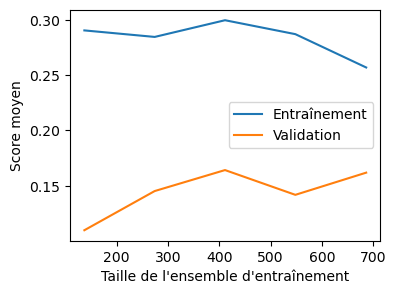

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


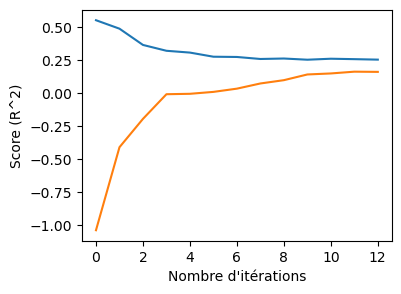

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - RobustScaler + TargetEncoder:
 Test score: 0.2735616733462689
 Params: {'regressor__n_neighbors': 7}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
5    {'regressor__n_neighbors': 7}          0.492607         0.273562
4    {'regressor__n_neighbors': 6}          0.517640         0.227232
12  {'regressor__n_neighbors': 14}          0.324890         0.224396
11  {'regressor__n_neighbors': 13}          0.335010         0.223083
10  {'regressor__n_neighbors': 12}          0.347480         0.220452
6    {'regressor__n_neighbors': 8}          0.444425         0.214789
9   {'regressor__n_neighbors': 11}          0.367773         0.209562
8   {'regressor__n_neighbors': 10}          0.388999         0.198228
7    {'regressor__n_neighbors': 9}          0

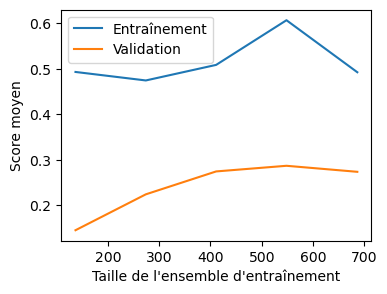

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


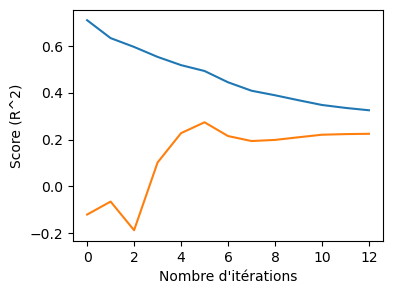

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - StandardScaler + TargetEncoder:
 Test score: 0.2593792077850784
 Params: {'regressor__n_neighbors': 7}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
5    {'regressor__n_neighbors': 7}          0.489976         0.259379
11  {'regressor__n_neighbors': 13}          0.334675         0.213751
12  {'regressor__n_neighbors': 14}          0.324771         0.212839
4    {'regressor__n_neighbors': 6}          0.514469         0.212722
6    {'regressor__n_neighbors': 8}          0.442343         0.212260
10  {'regressor__n_neighbors': 12}          0.346625         0.211460
9   {'regressor__n_neighbors': 11}          0.365202         0.201039
8   {'regressor__n_neighbors': 10}          0.386822         0.190009
7    {'regressor__n_neighbors': 9}         

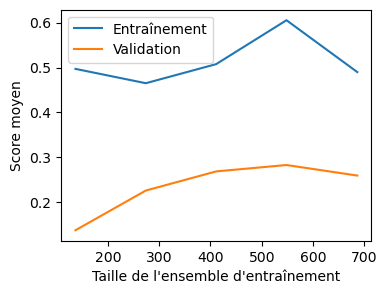

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


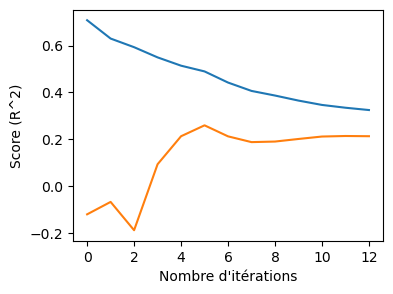

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - MinMaxScaler + TargetEncoder:
 Test score: 0.24054676705653585
 Params: {'regressor__n_neighbors': 7}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
5    {'regressor__n_neighbors': 7}          0.485497         0.240547
11  {'regressor__n_neighbors': 13}          0.328941         0.209453
12  {'regressor__n_neighbors': 14}          0.319230         0.208979
10  {'regressor__n_neighbors': 12}          0.340586         0.203659
4    {'regressor__n_neighbors': 6}          0.512993         0.196483
9   {'regressor__n_neighbors': 11}          0.360854         0.191950
6    {'regressor__n_neighbors': 8}          0.439040         0.188770
8   {'regressor__n_neighbors': 10}          0.382936         0.177434
7    {'regressor__n_neighbors': 9}          

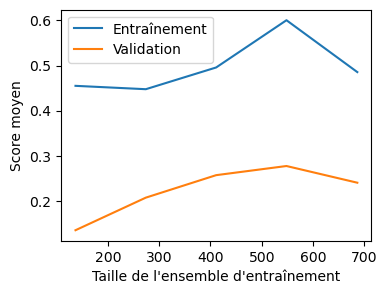

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


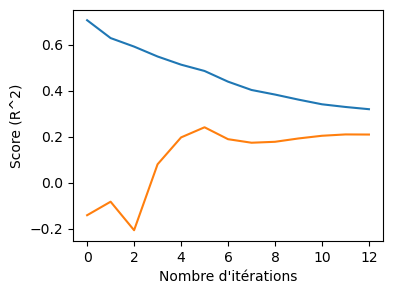

Fitting 5 folds for each of 13 candidates, totalling 65 fits
------------------------------
| Meilleur Model - KNN |
------------------------------
KNN - PolynomialFeatures + TargetEncoder:
 Test score: 0.16192853961869563
 Params: {'regressor__n_neighbors': 13}

------------------------
| Details Models |
------------------------
                            params  mean_train_score  mean_test_score
11  {'regressor__n_neighbors': 13}          0.256926         0.161929
12  {'regressor__n_neighbors': 14}          0.253291         0.160382
10  {'regressor__n_neighbors': 12}          0.260159         0.148443
9   {'regressor__n_neighbors': 11}          0.252671         0.140725
8   {'regressor__n_neighbors': 10}          0.261762         0.097426
7    {'regressor__n_neighbors': 9}          0.258233         0.072383
6    {'regressor__n_neighbors': 8}          0.273496         0.033028
5    {'regressor__n_neighbors': 7}          0.275441         0.008502
4    {'regressor__n_neighbors': 6}   

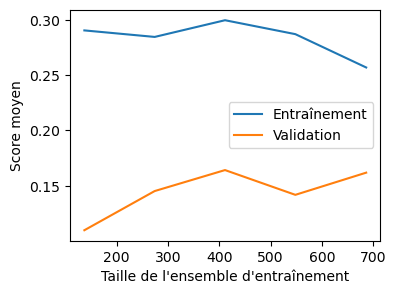

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


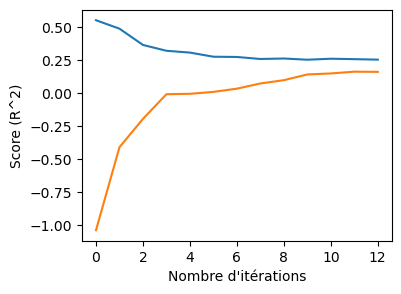

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - RobustScaler + OneHotEncoder:
 Test score: 0.2522730914890509
 Params: {'regressor__alpha': 4.894005834370745, 'regressor__l1_ratio': 0.5}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
12   {'regressor__alpha': 4.894005834370745, 'regre...          0.218260   
5    {'regressor__alpha': 2.2122654732913327, 'regr...          0.231385   
24   {'regressor__alpha': 23.950741614299556, 'regr...          0.209615   
11   {'regressor__alpha': 4.894005834370745, 'regre...          0.198001   
18   {'regressor__alpha': 10.826590839127904, 'regr...          0.198364   
..                                                 ...               ...   
76   {'regressor__alpha': 148736.86406843894, 'regr...          0.000000   

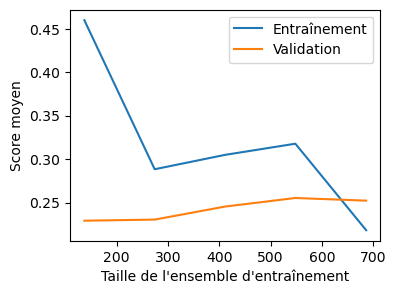

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


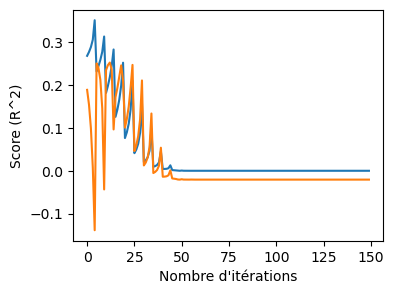

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - StandardScaler + OneHotEncoder:
 Test score: 0.12279777627149221
 Params: {'regressor__alpha': 4.894005834370745, 'regressor__l1_ratio': 0.5}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
12  {'regressor__alpha': 4.894005834370745, 'regre...          0.145466   
5   {'regressor__alpha': 2.2122654732913327, 'regr...          0.163836   
11  {'regressor__alpha': 4.894005834370745, 'regre...          0.119969   
18  {'regressor__alpha': 10.826590839127904, 'regr...          0.120428   
24  {'regressor__alpha': 23.950741614299556, 'regr...          0.135180   
..                                                ...               ...   
2   {'regressor__alpha': 1.0000230261160268, 'regr...          0.265323   
14  

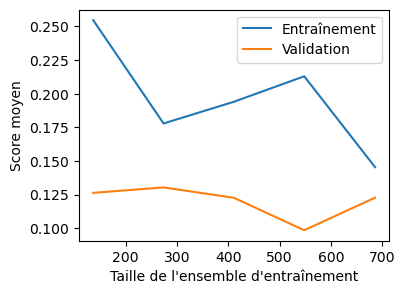

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


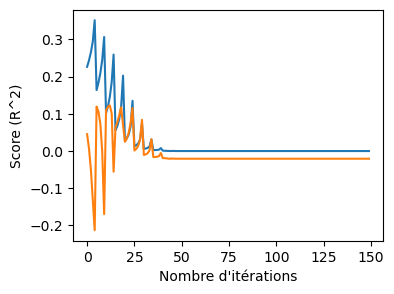

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - MinMaxScaler + OneHotEncoder:
 Test score: 0.18952231961442836
 Params: {'regressor__alpha': 1.0000230261160268, 'regressor__l1_ratio': 0.9}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
4    {'regressor__alpha': 1.0000230261160268, 'regr...          0.177762   
9    {'regressor__alpha': 2.2122654732913327, 'regr...          0.096199   
3    {'regressor__alpha': 1.0000230261160268, 'regr...          0.079808   
2    {'regressor__alpha': 1.0000230261160268, 'regr...          0.052668   
14   {'regressor__alpha': 4.894005834370745, 'regre...          0.045309   
..                                                 ...               ...   
65   {'regressor__alpha': 30392.339922466195, 'regr...          0.000000 

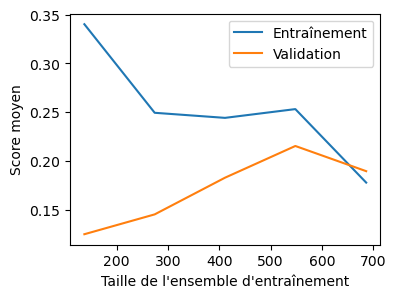

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


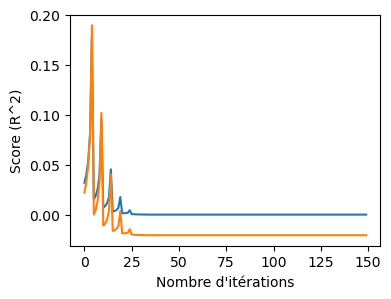

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - PolynomialFeatures + OneHotEncoder:
 Test score: 0.05074338245875758
 Params: {'regressor__alpha': 10000000000.0, 'regressor__l1_ratio': 0.9}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
149  {'regressor__alpha': 10000000000.0, 'regressor...          0.167749   
148  {'regressor__alpha': 10000000000.0, 'regressor...          0.167749   
147  {'regressor__alpha': 10000000000.0, 'regressor...          0.167749   
144  {'regressor__alpha': 4520357245.49924, 'regres...          0.167749   
143  {'regressor__alpha': 4520357245.49924, 'regres...          0.167749   
..                                                 ...               ...   
7    {'regressor__alpha': 2.2122654732913327, 'regr...          0.555777

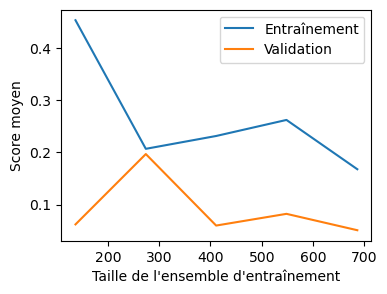

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


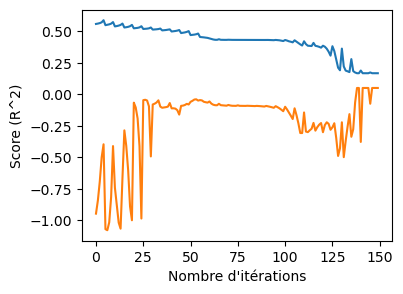

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - RobustScaler + TargetEncoder:
 Test score: 0.1469350240632283
 Params: {'regressor__alpha': 67234.37611646035, 'regressor__l1_ratio': 0.1}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
70  {'regressor__alpha': 67234.37611646035, 'regre...          0.206622   
65  {'regressor__alpha': 30392.339922466195, 'regr...          0.281986   
71  {'regressor__alpha': 67234.37611646035, 'regre...          0.185738   
66  {'regressor__alpha': 30392.339922466195, 'regr...          0.276561   
72  {'regressor__alpha': 67234.37611646035, 'regre...          0.166759   
..                                                ...               ...   
35  {'regressor__alpha': 259.2989091049283, 'regre...          0.372727   
36  {'r

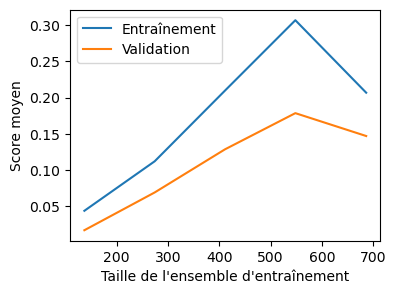

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


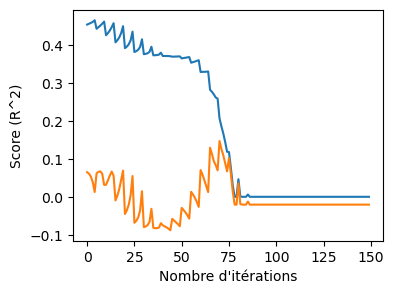

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - StandardScaler + TargetEncoder:
 Test score: 0.1469350240632283
 Params: {'regressor__alpha': 67234.37611646035, 'regressor__l1_ratio': 0.1}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
70  {'regressor__alpha': 67234.37611646035, 'regre...          0.206622   
65  {'regressor__alpha': 30392.339922466195, 'regr...          0.281986   
71  {'regressor__alpha': 67234.37611646035, 'regre...          0.185738   
66  {'regressor__alpha': 30392.339922466195, 'regr...          0.276561   
72  {'regressor__alpha': 67234.37611646035, 'regre...          0.166759   
..                                                ...               ...   
30  {'regressor__alpha': 117.21237025225103, 'regr...          0.371821   
31  {

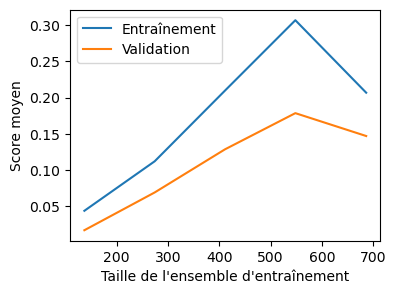

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


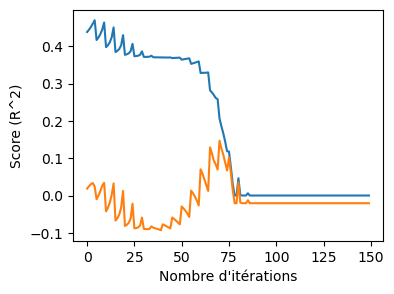

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - MinMaxScaler + TargetEncoder:
 Test score: 0.1469350240632283
 Params: {'regressor__alpha': 67234.37611646035, 'regressor__l1_ratio': 0.1}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
70  {'regressor__alpha': 67234.37611646035, 'regre...          0.206622   
65  {'regressor__alpha': 30392.339922466195, 'regr...          0.281986   
71  {'regressor__alpha': 67234.37611646035, 'regre...          0.185738   
66  {'regressor__alpha': 30392.339922466195, 'regr...          0.276561   
72  {'regressor__alpha': 67234.37611646035, 'regre...          0.166759   
..                                                ...               ...   
28  {'regressor__alpha': 52.984178713190175, 'regr...          0.370437   
22  {'r

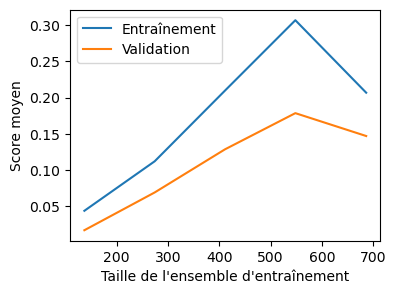

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


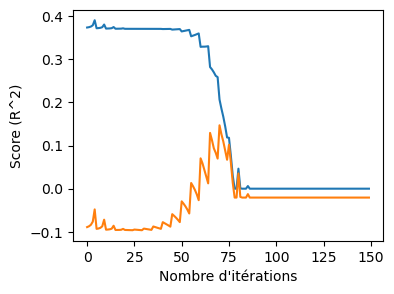

Fitting 5 folds for each of 150 candidates, totalling 750 fits
-------------------------------------
| Meilleur Model - ElasticNet |
-------------------------------------
ElasticNet - PolynomialFeatures + TargetEncoder:
 Test score: 0.1234643500953807
 Params: {'regressor__alpha': 13738.423397619588, 'regressor__l1_ratio': 0.1}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
60  {'regressor__alpha': 13738.423397619588, 'regr...          0.519596   
54  {'regressor__alpha': 2807.2585536501006, 'regr...          0.564299   
63  {'regressor__alpha': 13738.423397619588, 'regr...          0.501128   
56  {'regressor__alpha': 6210.258174716592, 'regre...          0.536200   
64  {'regressor__alpha': 13738.423397619588, 'regr...          0.495173   
..                                                ...               ...   
2   {'regressor__alpha': 1.0000230261160268, 'regr...          0.625874   


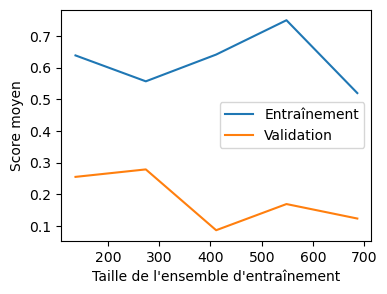

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


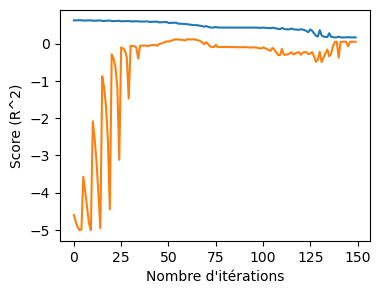

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - RobustScaler + OneHotEncoder:
 Test score: 0.09366711371125627
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 23}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.332958   
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.163216   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.464665   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.573428   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.580366   
..                                                 ...               ...   
9    {'regressor__learning_rate': 1, 'regressor__n_.

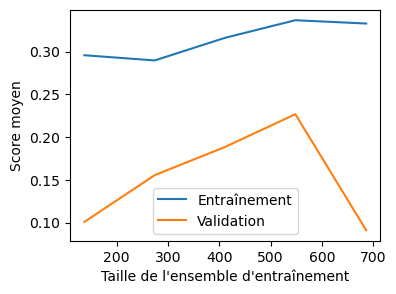

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


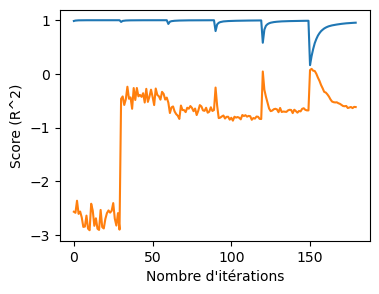

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - StandardScaler + OneHotEncoder:
 Test score: 0.10011540175736407
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 23}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.332958   
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.163216   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.580366   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.464665   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.573428   
..                                                 ...               ...   
20   {'regressor__learning_rate': 1, 'regressor__n

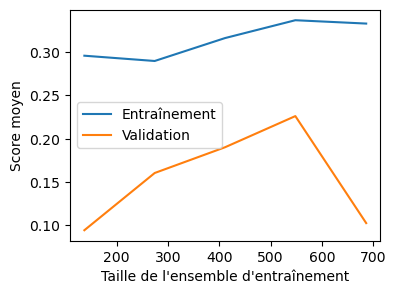

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


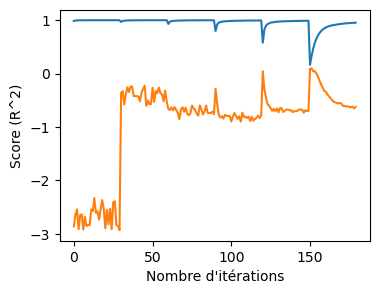

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - MinMaxScaler + OneHotEncoder:
 Test score: 0.09482081816916113
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 23}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.332958   
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.163216   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.464665   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.573428   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.580366   
..                                                 ...               ...   
2    {'regressor__learning_rate': 1, 'regressor__n_.

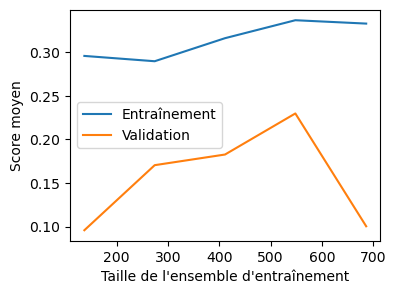

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


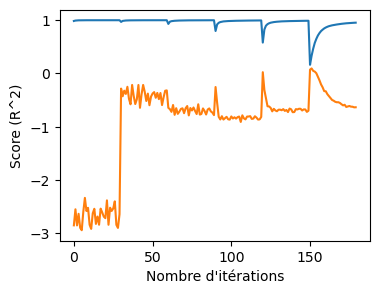

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - PolynomialFeatures + OneHotEncoder:
 Test score: 0.08612097353328614
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 23}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.337798   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.467551   
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.166277   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.580508   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.573912   
..                                                 ...               ...   
25   {'regressor__learning_rate': 1, 'regresso

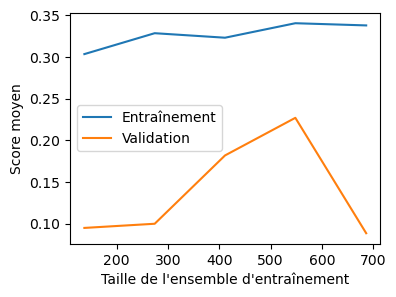

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


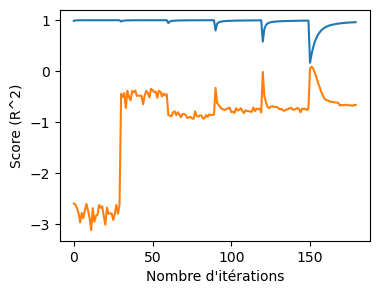

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - RobustScaler + TargetEncoder:
 Test score: 0.07708426309862178
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 10}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.139761   
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.293092   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.420618   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.532564   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.533224   
..                                                 ...               ...   
28   {'regressor__learning_rate': 1, 'regressor__n_.

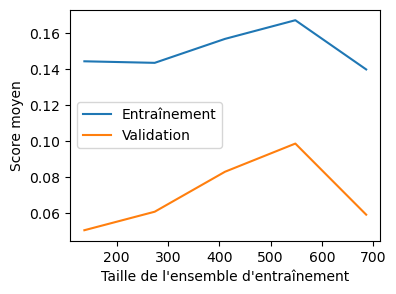

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


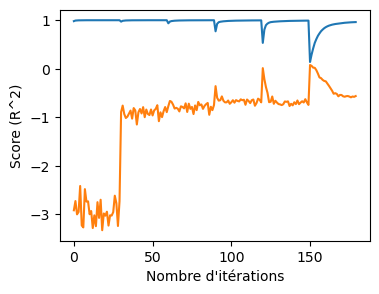

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - StandardScaler + TargetEncoder:
 Test score: 0.06111581891724076
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 23}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.293092   
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.139761   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.533224   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.532564   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.420618   
..                                                 ...               ...   
18   {'regressor__learning_rate': 1, 'regressor__n

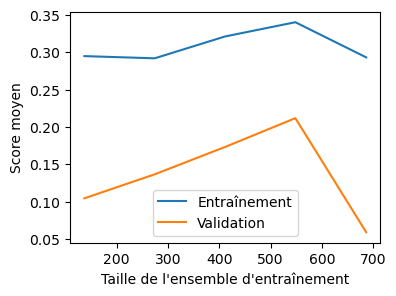

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


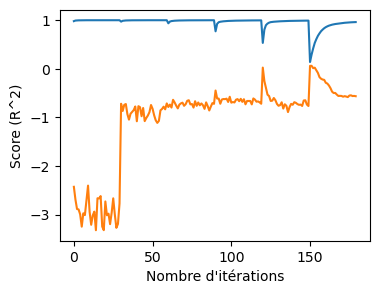

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - MinMaxScaler + TargetEncoder:
 Test score: 0.06572651525925503
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 10}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.139761   
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.293092   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.532564   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.420618   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.533224   
..                                                 ...               ...   
3    {'regressor__learning_rate': 1, 'regressor__n_.

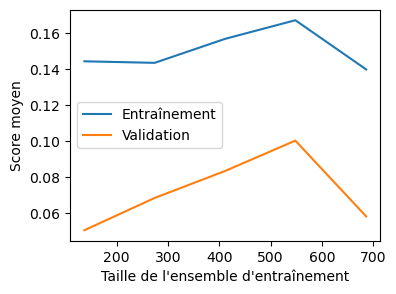

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


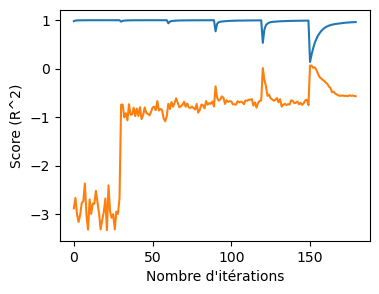

Fitting 5 folds for each of 180 candidates, totalling 900 fits
-------------------------------------------
| Meilleur Model - GradientBoosting |
-------------------------------------------
GradientBoosting - PolynomialFeatures + TargetEncoder:
 Test score: 0.06755987752486052
 Params: {'regressor__learning_rate': 0.01, 'regressor__n_estimators': 23}

------------------------
| Details Models |
------------------------
                                                params  mean_train_score  \
151  {'regressor__learning_rate': 0.01, 'regressor_...          0.327452   
150  {'regressor__learning_rate': 0.01, 'regressor_...          0.162730   
152  {'regressor__learning_rate': 0.01, 'regressor_...          0.455748   
120  {'regressor__learning_rate': 0.05, 'regressor_...          0.568753   
153  {'regressor__learning_rate': 0.01, 'regressor_...          0.561928   
..                                                 ...               ...   
15   {'regressor__learning_rate': 1, 'regresso

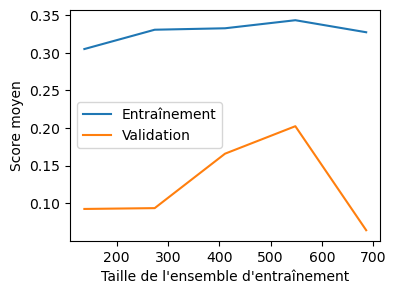

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


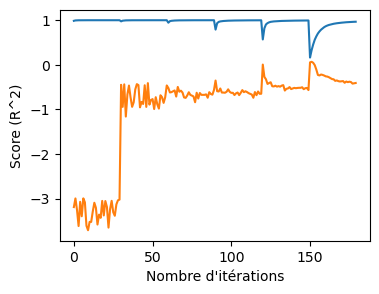

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - RobustScaler + OneHotEncoder:
 Test score: 0.20879413339669456
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.280415         0.208794
4   {'regressor__C': 100.0}          0.092886         0.123030
3    {'regressor__C': 10.0}          0.025752         0.047450
2     {'regressor__C': 1.0}         -0.017808        -0.019919
1     {'regressor__C': 0.1}         -0.030823        -0.042265
0    {'regressor__C': 0.01}         -0.032219        -0.044528
--------------------------------
| Courbe d'apprentissage |
--------------------------------


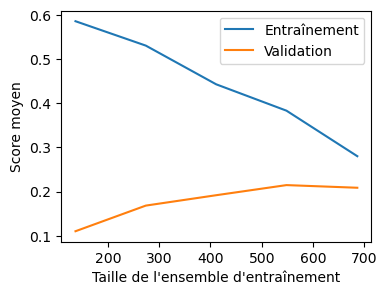

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


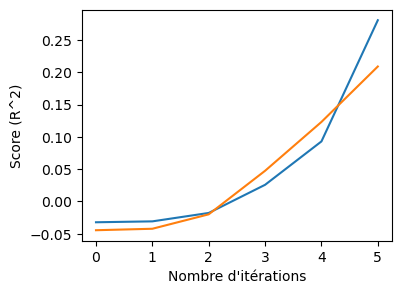

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - StandardScaler + OneHotEncoder:
 Test score: 0.24047423673582263
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.305902         0.240474
4   {'regressor__C': 100.0}          0.084525         0.107514
3    {'regressor__C': 10.0}          0.009921         0.020022
2     {'regressor__C': 1.0}         -0.024361        -0.031442
1     {'regressor__C': 0.1}         -0.031415        -0.043216
0    {'regressor__C': 0.01}         -0.032299        -0.044654
--------------------------------
| Courbe d'apprentissage |
--------------------------------


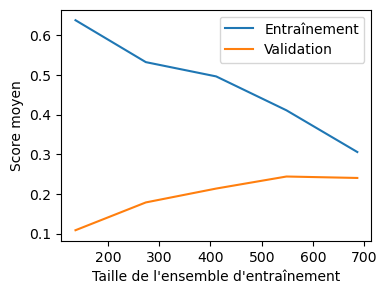

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


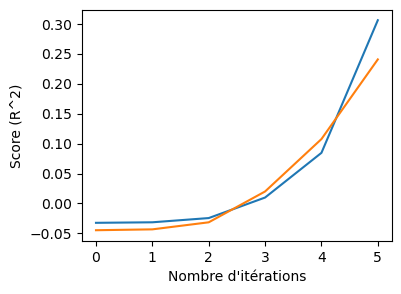

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - MinMaxScaler + OneHotEncoder:
 Test score: 0.3253722536181042
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.306554         0.325372
4   {'regressor__C': 100.0}          0.049157         0.061757
3    {'regressor__C': 10.0}         -0.011087        -0.011151
2     {'regressor__C': 1.0}         -0.028682        -0.037807
1     {'regressor__C': 0.1}         -0.032029        -0.044109
0    {'regressor__C': 0.01}         -0.032364        -0.044761
--------------------------------
| Courbe d'apprentissage |
--------------------------------


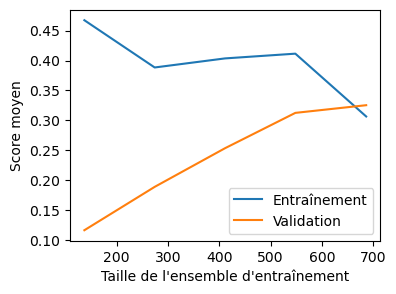

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


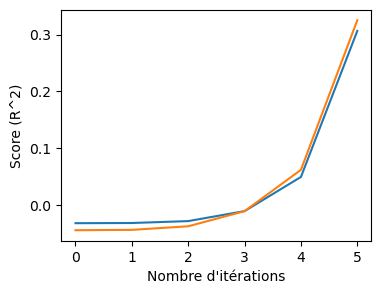

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - PolynomialFeatures + OneHotEncoder:
 Test score: 0.08911791985709194
 Params: {'regressor__C': 100.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
4   {'regressor__C': 100.0}          0.075216         0.089118
5  {'regressor__C': 1000.0}          0.149220         0.087042
3    {'regressor__C': 10.0}          0.022582         0.033782
2     {'regressor__C': 1.0}         -0.020158        -0.026665
1     {'regressor__C': 0.1}         -0.031064        -0.042821
0    {'regressor__C': 0.01}         -0.032251        -0.044598
--------------------------------
| Courbe d'apprentissage |
--------------------------------


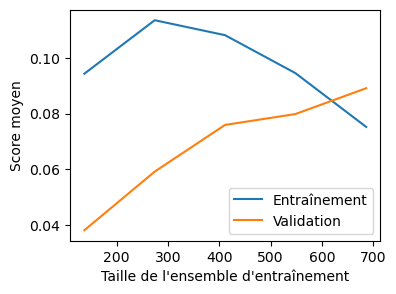

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


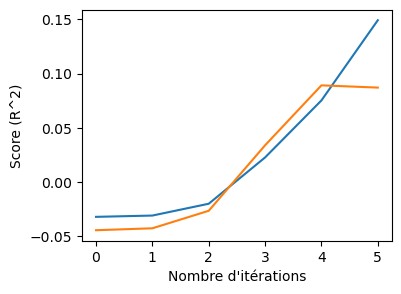

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - RobustScaler + TargetEncoder:
 Test score: 0.2846761682715685
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.279620         0.284676
4   {'regressor__C': 100.0}          0.054637         0.056830
3    {'regressor__C': 10.0}         -0.001299        -0.001635
2     {'regressor__C': 1.0}         -0.021970        -0.028669
1     {'regressor__C': 0.1}         -0.030825        -0.042327
0    {'regressor__C': 0.01}         -0.032222        -0.044472
--------------------------------
| Courbe d'apprentissage |
--------------------------------


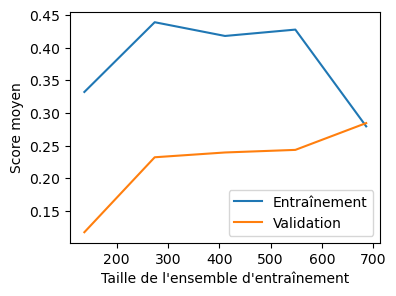

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


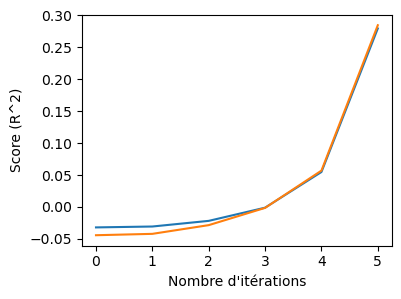

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - StandardScaler + TargetEncoder:
 Test score: 0.2804556916329951
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.277495         0.280456
4   {'regressor__C': 100.0}          0.054300         0.056272
3    {'regressor__C': 10.0}         -0.001347        -0.001712
2     {'regressor__C': 1.0}         -0.021976        -0.028683
1     {'regressor__C': 0.1}         -0.030826        -0.042329
0    {'regressor__C': 0.01}         -0.032222        -0.044472
--------------------------------
| Courbe d'apprentissage |
--------------------------------


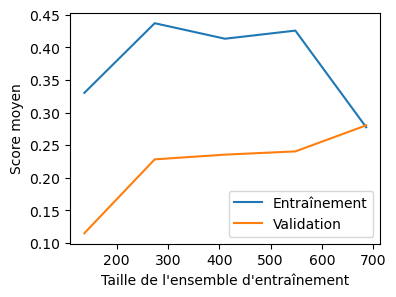

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


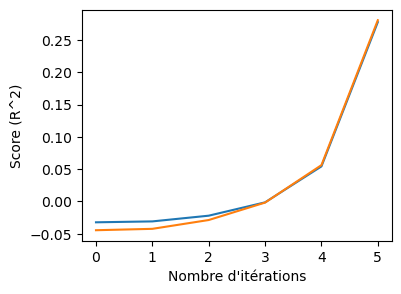

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - MinMaxScaler + TargetEncoder:
 Test score: 0.2792324776654239
 Params: {'regressor__C': 1000.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
5  {'regressor__C': 1000.0}          0.276890         0.279232
4   {'regressor__C': 100.0}          0.054202         0.056097
3    {'regressor__C': 10.0}         -0.001360        -0.001732
2     {'regressor__C': 1.0}         -0.021975        -0.028679
1     {'regressor__C': 0.1}         -0.030825        -0.042328
0    {'regressor__C': 0.01}         -0.032222        -0.044472
--------------------------------
| Courbe d'apprentissage |
--------------------------------


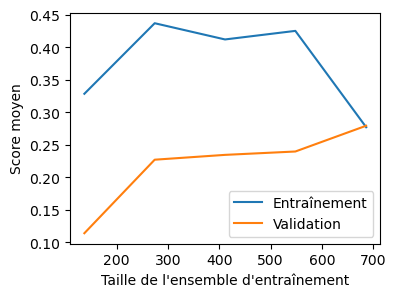

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


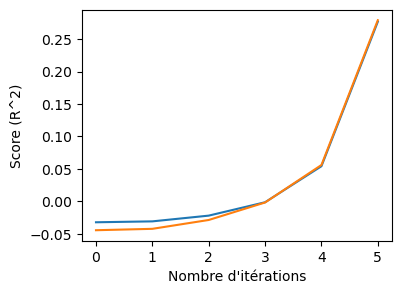

Fitting 5 folds for each of 6 candidates, totalling 30 fits
------------------------------
| Meilleur Model - SVR |
------------------------------
SVR - PolynomialFeatures + TargetEncoder:
 Test score: 0.08914064787374791
 Params: {'regressor__C': 100.0}

------------------------
| Details Models |
------------------------
                     params  mean_train_score  mean_test_score
4   {'regressor__C': 100.0}          0.075232         0.089141
5  {'regressor__C': 1000.0}          0.149228         0.087076
3    {'regressor__C': 10.0}          0.022589         0.033797
2     {'regressor__C': 1.0}         -0.020153        -0.026659
1     {'regressor__C': 0.1}         -0.031064        -0.042821
0    {'regressor__C': 0.01}         -0.032251        -0.044598
--------------------------------
| Courbe d'apprentissage |
--------------------------------


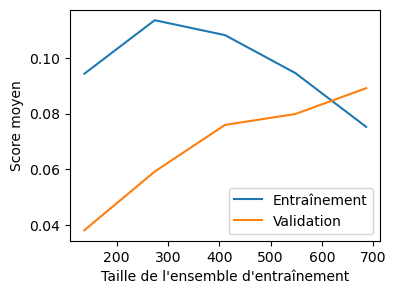

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


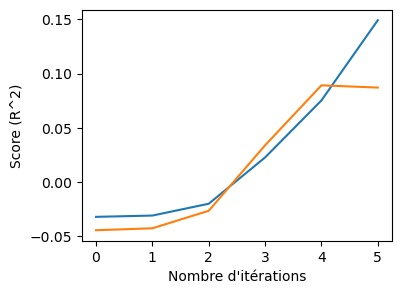

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - RobustScaler + OneHotEncoder:
 Test score: 0.2505760222630496
 Params: {'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 80}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
7   {'regressor__min_samples_leaf': 1, 'regressor_...          0.912075   
4   {'regressor__min_samples_leaf': 1, 'regressor_...          0.922021   
9   {'regressor__min_samples_leaf': 1, 'regressor_...          0.916397   
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.565357   
14  {'regressor__min_samples_leaf': 1, 'regressor_...          0.918922   
38  {'regressor__min_samples_leaf': 4, 'regressor_...          0.562497   
15  {'regressor__min_samples_leaf': 1, 'regressor_...          0.928974   
34

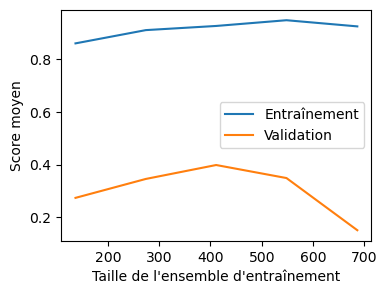

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


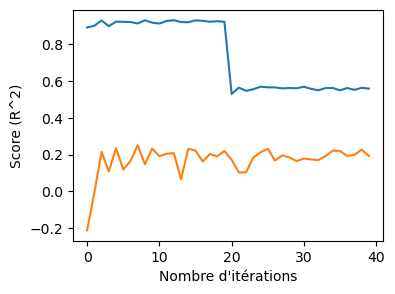

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - StandardScaler + OneHotEncoder:
 Test score: 0.2591746024409593
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 40}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
23  {'regressor__min_samples_leaf': 4, 'regressor_...          0.555648   
3   {'regressor__min_samples_leaf': 1, 'regressor_...          0.900332   
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.550387   
33  {'regressor__min_samples_leaf': 4, 'regressor_...          0.564393   
29  {'regressor__min_samples_leaf': 4, 'regressor_...          0.555837   
34  {'regressor__min_samples_leaf': 4, 'regressor_...          0.563388   
38  {'regressor__min_samples_leaf': 4, 'regressor_...          0.566511   


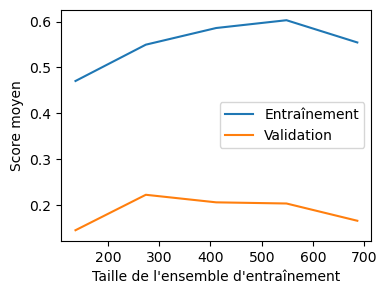

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


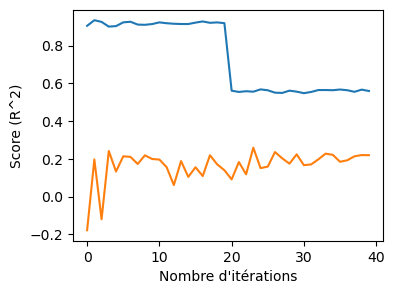

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - MinMaxScaler + OneHotEncoder:
 Test score: 0.2941702217265687
 Params: {'regressor__min_samples_leaf': 1, 'regressor__n_estimators': 40}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
3   {'regressor__min_samples_leaf': 1, 'regressor_...          0.923454   
14  {'regressor__min_samples_leaf': 1, 'regressor_...          0.925696   
19  {'regressor__min_samples_leaf': 1, 'regressor_...          0.925485   
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.557983   
24  {'regressor__min_samples_leaf': 4, 'regressor_...          0.558426   
5   {'regressor__min_samples_leaf': 1, 'regressor_...          0.916477   
16  {'regressor__min_samples_leaf': 1, 'regressor_...          0.922589   
1 

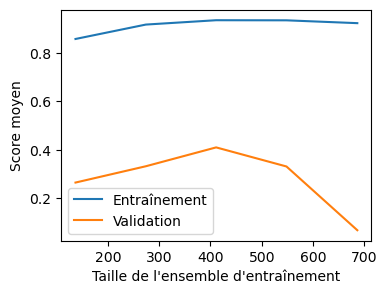

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


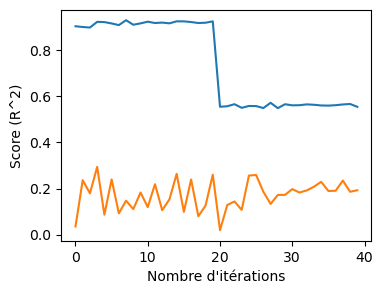

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - PolynomialFeatures + OneHotEncoder:
 Test score: 0.24200451389779642
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 60}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.592138   
29  {'regressor__min_samples_leaf': 4, 'regressor_...          0.578624   
23  {'regressor__min_samples_leaf': 4, 'regressor_...          0.585014   
33  {'regressor__min_samples_leaf': 4, 'regressor_...          0.584638   
19  {'regressor__min_samples_leaf': 1, 'regressor_...          0.912119   
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.561582   
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.58873

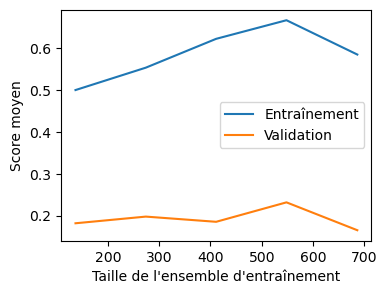

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


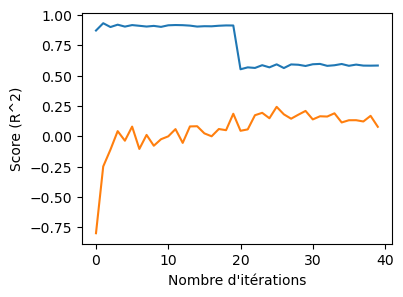

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - RobustScaler + TargetEncoder:
 Test score: 0.41268203299940714
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 90}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.629661   
39  {'regressor__min_samples_leaf': 4, 'regressor_...          0.617822   
30  {'regressor__min_samples_leaf': 4, 'regressor_...          0.614329   
34  {'regressor__min_samples_leaf': 4, 'regressor_...          0.612030   
36  {'regressor__min_samples_leaf': 4, 'regressor_...          0.611175   
32  {'regressor__min_samples_leaf': 4, 'regressor_...          0.615513   
33  {'regressor__min_samples_leaf': 4, 'regressor_...          0.609927   
3

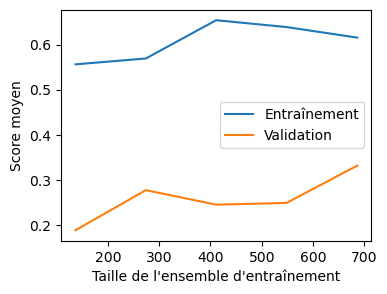

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


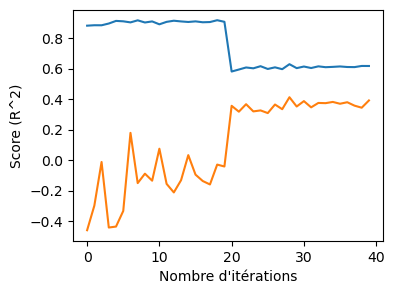

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - StandardScaler + TargetEncoder:
 Test score: 0.38532331182128937
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 80}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
27  {'regressor__min_samples_leaf': 4, 'regressor_...          0.620677   
36  {'regressor__min_samples_leaf': 4, 'regressor_...          0.613799   
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.607509   
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.609864   
21  {'regressor__min_samples_leaf': 4, 'regressor_...          0.587110   
32  {'regressor__min_samples_leaf': 4, 'regressor_...          0.613779   
31  {'regressor__min_samples_leaf': 4, 'regressor_...          0.616608   

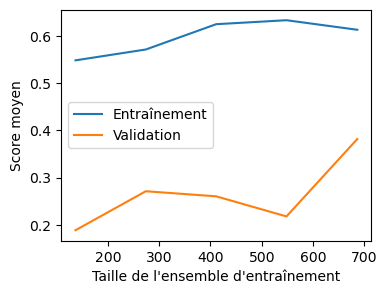

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


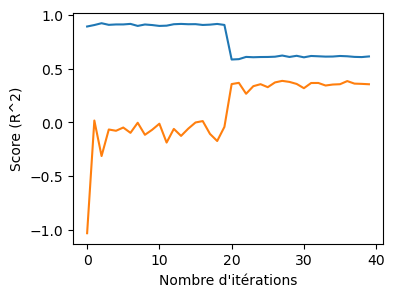

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - MinMaxScaler + TargetEncoder:
 Test score: 0.41090114882666884
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 70}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
26  {'regressor__min_samples_leaf': 4, 'regressor_...          0.616954   
34  {'regressor__min_samples_leaf': 4, 'regressor_...          0.626553   
39  {'regressor__min_samples_leaf': 4, 'regressor_...          0.606733   
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.615907   
32  {'regressor__min_samples_leaf': 4, 'regressor_...          0.611213   
23  {'regressor__min_samples_leaf': 4, 'regressor_...          0.601190   
25  {'regressor__min_samples_leaf': 4, 'regressor_...          0.614531   
2

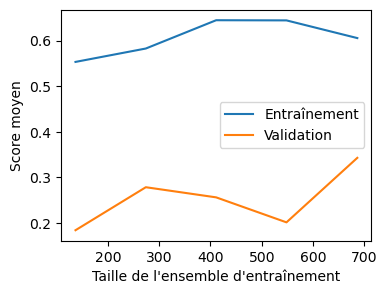

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


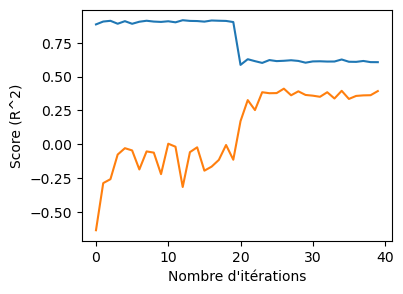

Fitting 5 folds for each of 40 candidates, totalling 200 fits
---------------------------------------
| Meilleur Model - RandomForest |
---------------------------------------
RandomForest - PolynomialFeatures + TargetEncoder:
 Test score: 0.4855068471032279
 Params: {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 20}

------------------------
| Details Models |
------------------------
                                               params  mean_train_score  \
21  {'regressor__min_samples_leaf': 4, 'regressor_...          0.651494   
20  {'regressor__min_samples_leaf': 4, 'regressor_...          0.617583   
30  {'regressor__min_samples_leaf': 4, 'regressor_...          0.625900   
38  {'regressor__min_samples_leaf': 4, 'regressor_...          0.626563   
27  {'regressor__min_samples_leaf': 4, 'regressor_...          0.631894   
35  {'regressor__min_samples_leaf': 4, 'regressor_...          0.626993   
28  {'regressor__min_samples_leaf': 4, 'regressor_...          0.634031

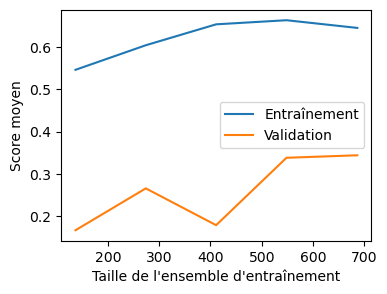

-------------------------------------------------------
| Scores Moyens d'Entraînement et de Validation |
-------------------------------------------------------


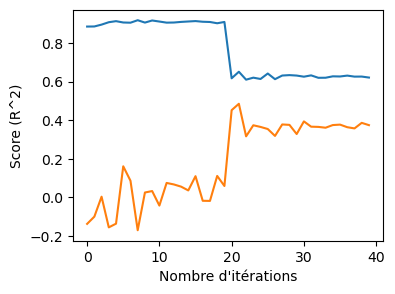

In [48]:
models_no_energy_star = run_models_with_preprocessors(models, preprocessor_configs, grid_configs, X_train, y_train, X_test, y_test, numeric_features, categorical_features)

In [51]:
selected_models = []

for result_key, result_info in models_no_energy_star.items():
    test_score = result_info["Test score"]
    
    if test_score > 0.40:
        selected_models.append((result_key, result_info["Params"], test_score))

print_titre("Les modèles ayant un score de test supérieur à 0.50 sont :")

for model, config, test_score in selected_models:
    print(f"Nom du modèle : {model}\nConfiguration : {config}\nTest Score : {test_score}")

--------------------------------------------------------------------
| Les modèles ayant un score de test supérieur à 0.50 sont : |
--------------------------------------------------------------------
Nom du modèle : RandomForest - RobustScaler + TargetEncoder
Configuration : {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 90}
Test Score : 0.41268203299940714
Nom du modèle : RandomForest - MinMaxScaler + TargetEncoder
Configuration : {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 70}
Test Score : 0.41090114882666884
Nom du modèle : RandomForest - PolynomialFeatures + TargetEncoder
Configuration : {'regressor__min_samples_leaf': 4, 'regressor__n_estimators': 20}
Test Score : 0.4855068471032279
